# Analysis
Load results files and run analysis on them

# TODO
- [ ] Handle missing files
- [ ] Perform analysis
    - [x] Plot results
    - [ ] Aggregate results <- Start design
- [ ] Options as a separate file
- [x] Avoid overwrites

# Functions

## Plotting

In [1]:
import matplotlib.pyplot as plt
from tigramite import plotting as tp
import numpy as np

def plot_links(results,
               save_name = None,
               figsize = (16, 16)
              ):
    """
    This function is copied from the basic tutorial, but it may not be
    generalizable: It had issues with output from pcmciplus
    """

    link_matrix = results["link_matrix"]
    var_names = np.array(results["var_names"])
    val_matrix = results['val_matrix']
    
    links = results["links"]
    linked_variables = set() # Avoids duplicates and sorts when list
    for child, parents_list in links.items():
        if len(parents_list) > 0:
            linked_variables.add(child)
            for parent in parents_list:
                linked_variables.add(parent[0])
    if len(linked_variables) != 0:
        linked_variables = list(linked_variables)
    else:
        linked_variables = range(len(links))
    
    tp.plot_graph(
        figsize = figsize,
        val_matrix = val_matrix[linked_variables][:,linked_variables],
        link_matrix = link_matrix[linked_variables][:,linked_variables],
        var_names = var_names[linked_variables],
        link_colorbar_label = 'cross-MCI',
        node_colorbar_label = 'auto-MCI',
        arrow_linewidth = 5,
        node_size = 0.15,
        save_name = save_name
    ); plt.show()

# Main program

## Options

In [2]:
"""
# Options
experiment = '002_train_1_year'  # "experiment" to be used

gridpoints = None # All

gridpoints = [
        [5, 120],             # "Tropical" region
        [6, 120],
        [7, 120],
        [8, 120],
        [5, 121],
        [6, 121],
        [7, 121],
        [8, 121],
        [5, 122]
]

#target_levels = [1000, 700, 300, 80] # Nearest level (hPa)
target_levels = None # all


# TODO
# Check with these values with a few columns, use selection for the rest
# Which alpha gives the right physics?
list_pc_alpha = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2]

verbosity = 2

output_folder = "./test_outputs"
plots_folder = "./test_outputs/plots"
PLOT_FILE_PATTERN = "{var_name}_{level}_lat{lat}_lon{lon}_a{pc_alpha}_{experiment}.png"

overwrite = False
"""
pass

In [3]:
"""
from pathlib import Path
from utils.constants import DATA_FOLDER, ANCIL_FILE
from utils.constants import SPCAM_Vars

import utils.utils as utils

levels, latitudes, longitudes = utils.read_ancilaries(
    Path(DATA_FOLDER, ANCIL_FILE))

# idx_levs format: target level, index of closest value
if target_levels is not None:
    idx_levs = [[lev, utils.find_closest_value(levels, lev)]
                        for lev in target_levels]
else:
    idx_levs = [[round(lev, 2), i] for i, lev in enumerate(levels)]
    
#print(levels[idx_levs])
for target, idx in idx_levs:
    print(f"target = {target},\tindex = {idx},\tlevel = {levels[idx]}")

if gridpoints is not None:
    idx_lats = [utils.find_closest_value(latitudes, gridpoint[0])
                        for gridpoint in gridpoints]
    idx_lons = [utils.find_closest_longitude(longitudes, gridpoint[1])
                        for gridpoint in gridpoints]
else:
    idx_lats = [idx_lat for idx_lat in range(len(latitudes))
                        for idx_lon in range(len(longitudes))]
    idx_lons = [idx_lon for idx_lat in range(len(latitudes))
                        for idx_lon in range(len(longitudes))]
    

Path(plots_folder).mkdir(parents=True, exist_ok=True)
"""
pass

## Specifications

In [4]:
import sys
import getopt
import yaml
import time
import datetime
from pathlib import Path

import utils.utils as utils
from utils.constants import SPCAM_Vars, DATA_FOLDER, ANCIL_FILE
from utils.constants import PLOT_FILE_PATTERN
from utils.constants import experiment

In [5]:
# argv           = sys.argv[1:]
argv           = ['-c', 'cfg_pipeline.yml']
try:
    opts, args = getopt.getopt(argv,"hc:a",["cfg_file=","add="])
except getopt.GetoptError:
    print ('pipeline.py -c [cfg_file] -a [add]')
    sys.exit(2)
for opt, arg in opts:
    if opt == '-h':
        print ('pipeline.py -c [cfg_file]')
        sys.exit()
    elif opt in ("-c", "--cfg_file"):
        yml_cfgFilenm = arg
    elif opt in ("-a", "--add"):
        pass

# YAML config file
yml_cfgFile       = open(yml_cfgFilenm)
yml_cfg           = yaml.load(yml_cfgFile, Loader=yaml.FullLoader)

# Load specifications
spcam_parents     = yml_cfg['spcam_parents']
spcam_children    = yml_cfg['spcam_children']
pc_alphas         = yml_cfg['pc_alphas']
region            = yml_cfg['region']
lim_levels        = yml_cfg['lim_levels']
target_levels     = yml_cfg['target_levels']
verbosity         = yml_cfg['verbosity']
output_folder     = yml_cfg['output_folder']
plots_folder = yml_cfg['plots_folder']
overwrite         = False

Path(plots_folder).mkdir(parents=True, exist_ok=True)

In [6]:
## Region / Gridpoints
if region is False:
    region     = [ [-90,90] , [0,-.5] ] # All
gridpoints = utils.get_gridpoints(region)

## Children levels (parents includes all)
if lim_levels is not False and target_levels is False:
    target_levels = utils.get_levels(lim_levels)

In [7]:
## Model's grid
levels, latitudes, longitudes = utils.read_ancilaries(Path(DATA_FOLDER, ANCIL_FILE))

## Latitude / Longitude indexes
idx_lats = [utils.find_closest_value(latitudes, gridpoint[0])      for gridpoint in gridpoints]
idx_lons = [utils.find_closest_longitude(longitudes, gridpoint[1]) for gridpoint in gridpoints]

## Level indexes (children & parents)
parents_idx_levs = [[round(lev, 2), i] for i, lev in enumerate(levels)] # All
if target_levels is not False:
    children_idx_levs = [[lev, utils.find_closest_value(levels, lev)] for lev in target_levels]
else:
    children_idx_levs = parents_idx_levs

In [8]:
## Variables
spcam_vars_include = spcam_parents + spcam_children
var_list = [var for var in SPCAM_Vars if var.label in spcam_vars_include]
var_parents = [var for var in var_list if var.type == "in"]
var_children = [var for var in var_list if var.type == "out"]  

## Plots

Gridpoint 1/1:lat=4.185920533189154 (33), lon=120.9375 (43)
Variable: tphystnd
Loading results from "causal_links/tphystnd_21_lat-4_lon-120_002_train_1_year.obj"
Plotting links for tphystnd at level 21
pc_alpha = 0.001


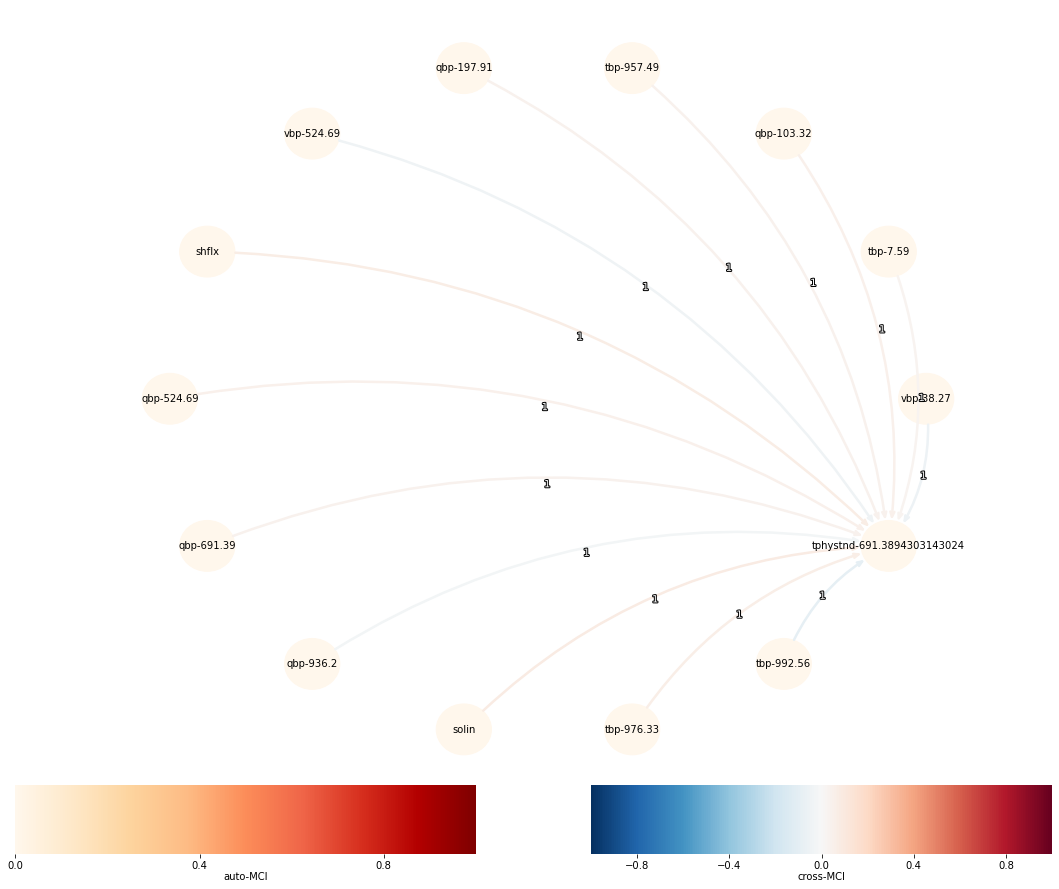

pc_alpha = 0.002


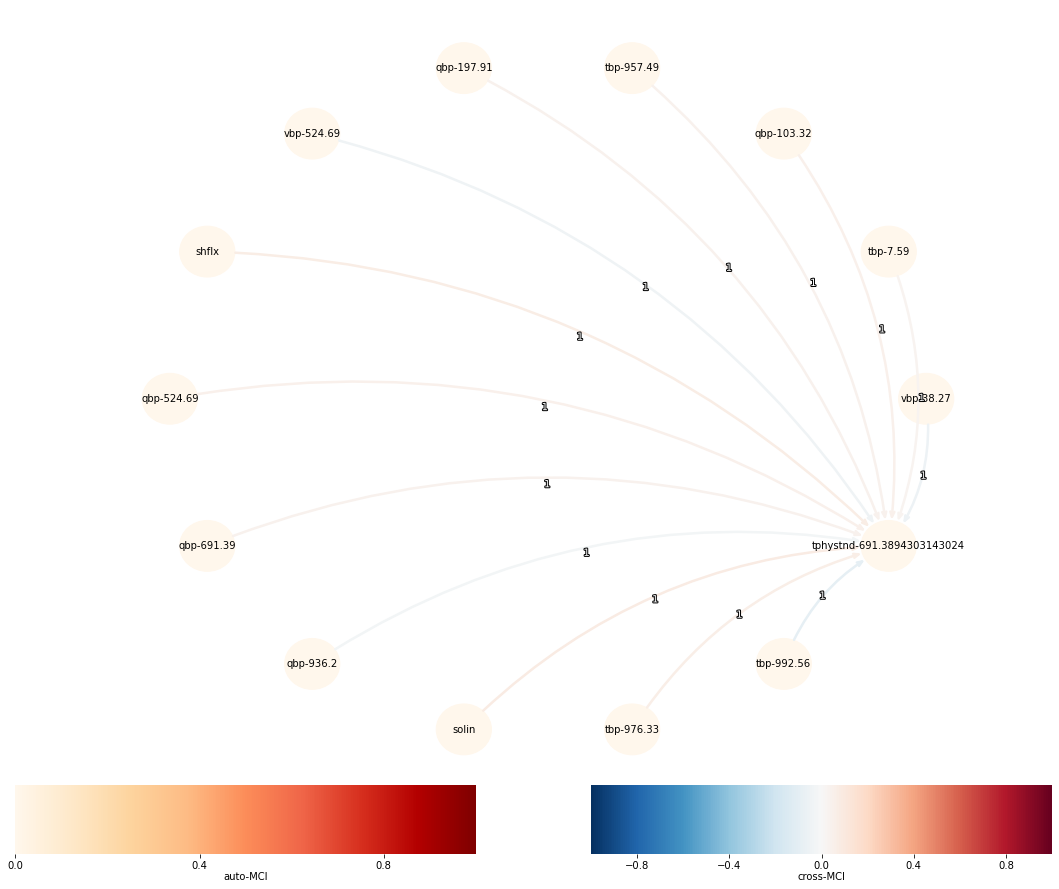

pc_alpha = 0.005


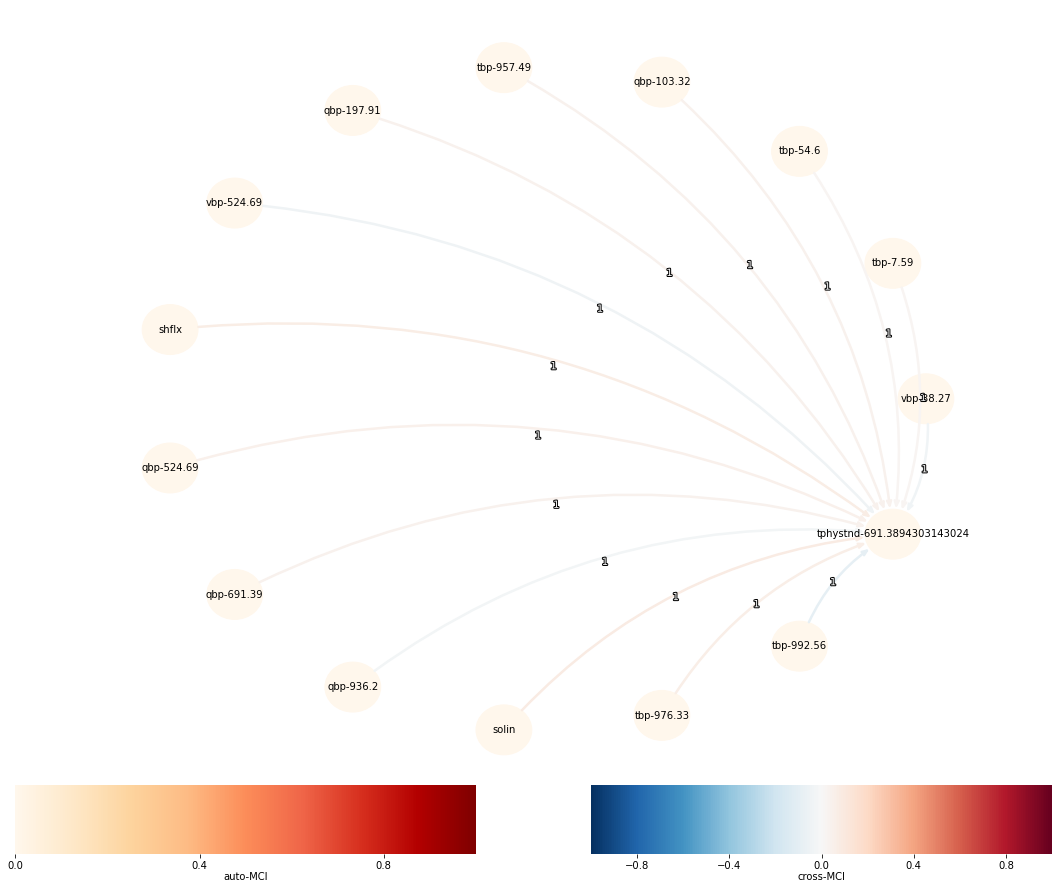

pc_alpha = 0.01


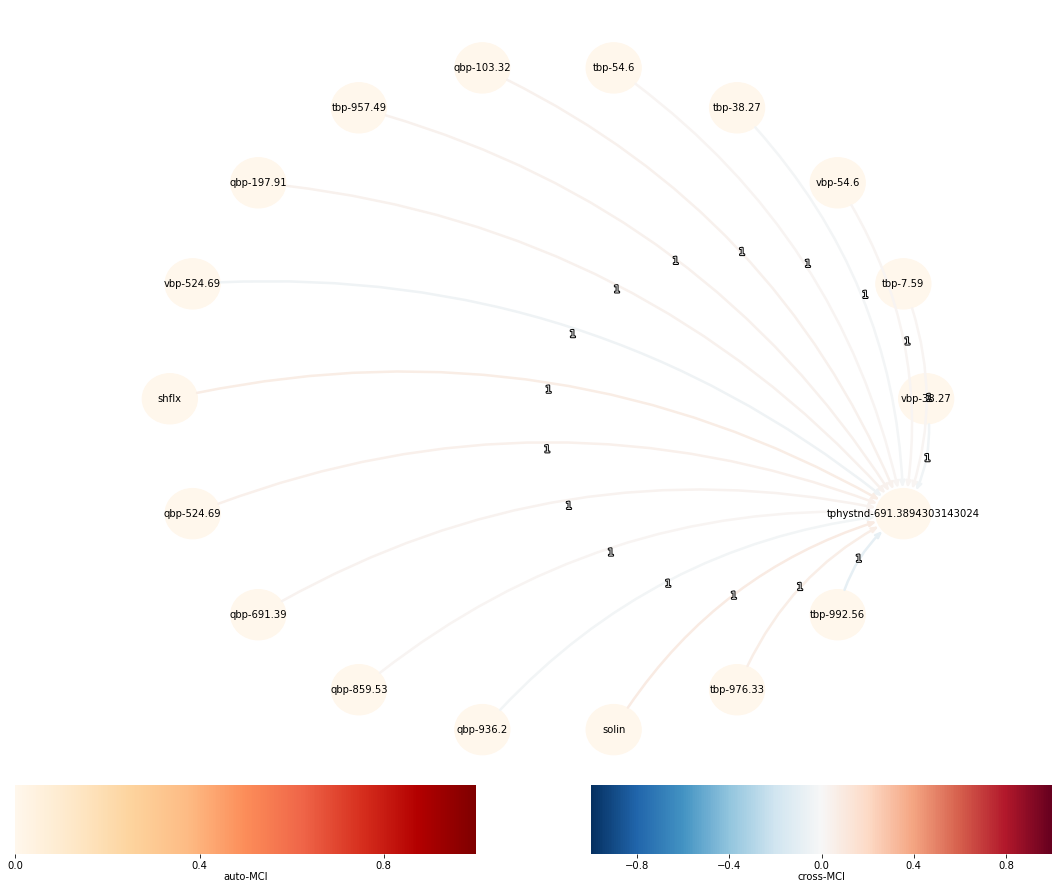

pc_alpha = 0.02


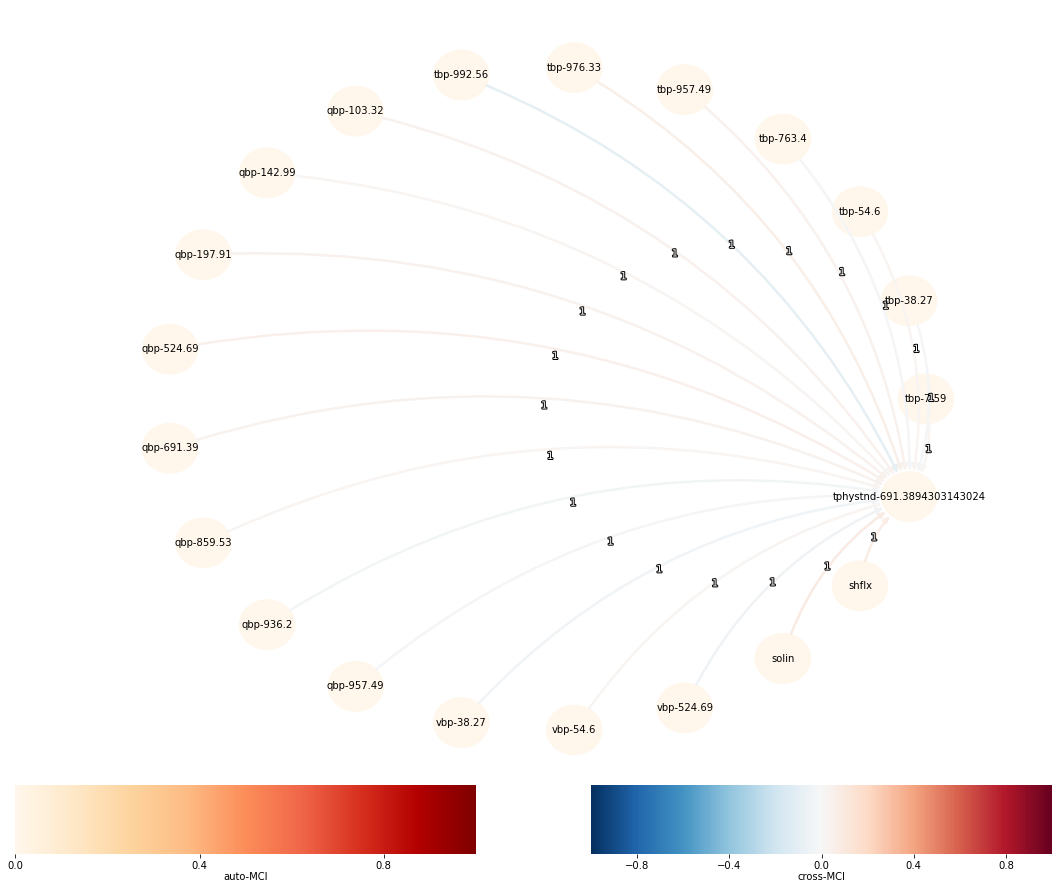

pc_alpha = 0.05


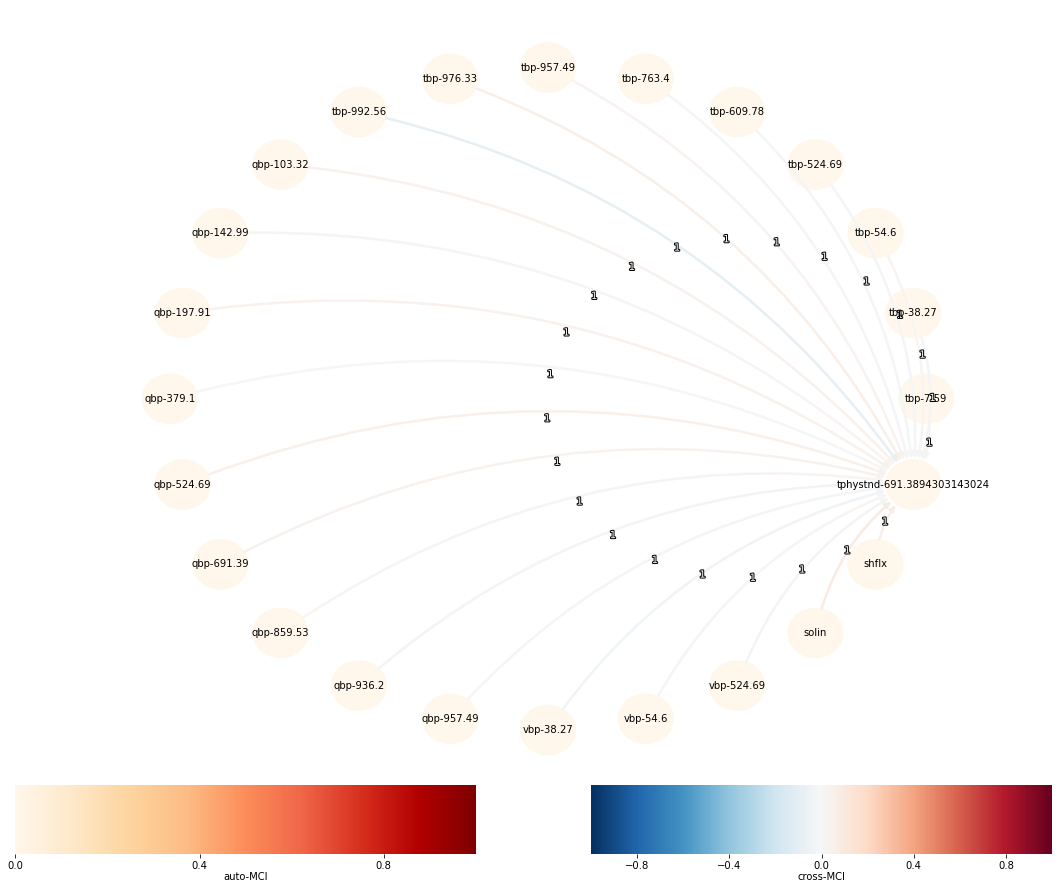

pc_alpha = 0.1


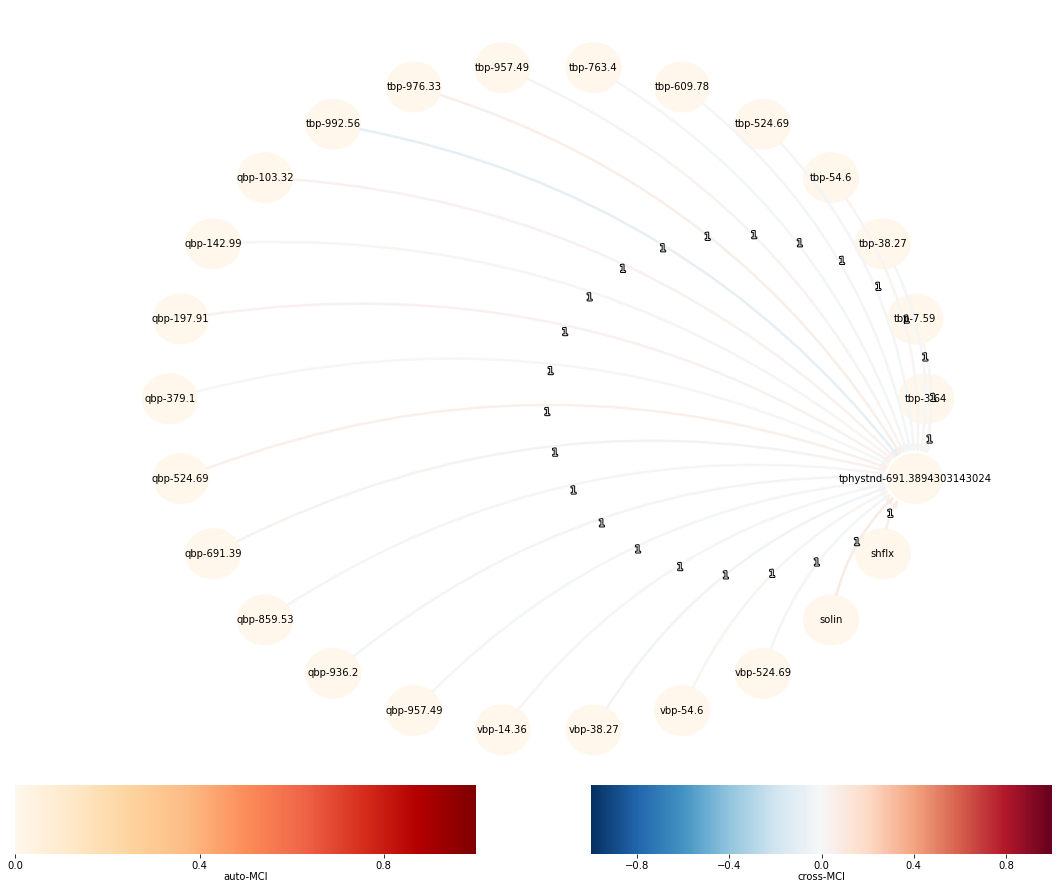

pc_alpha = 0.2


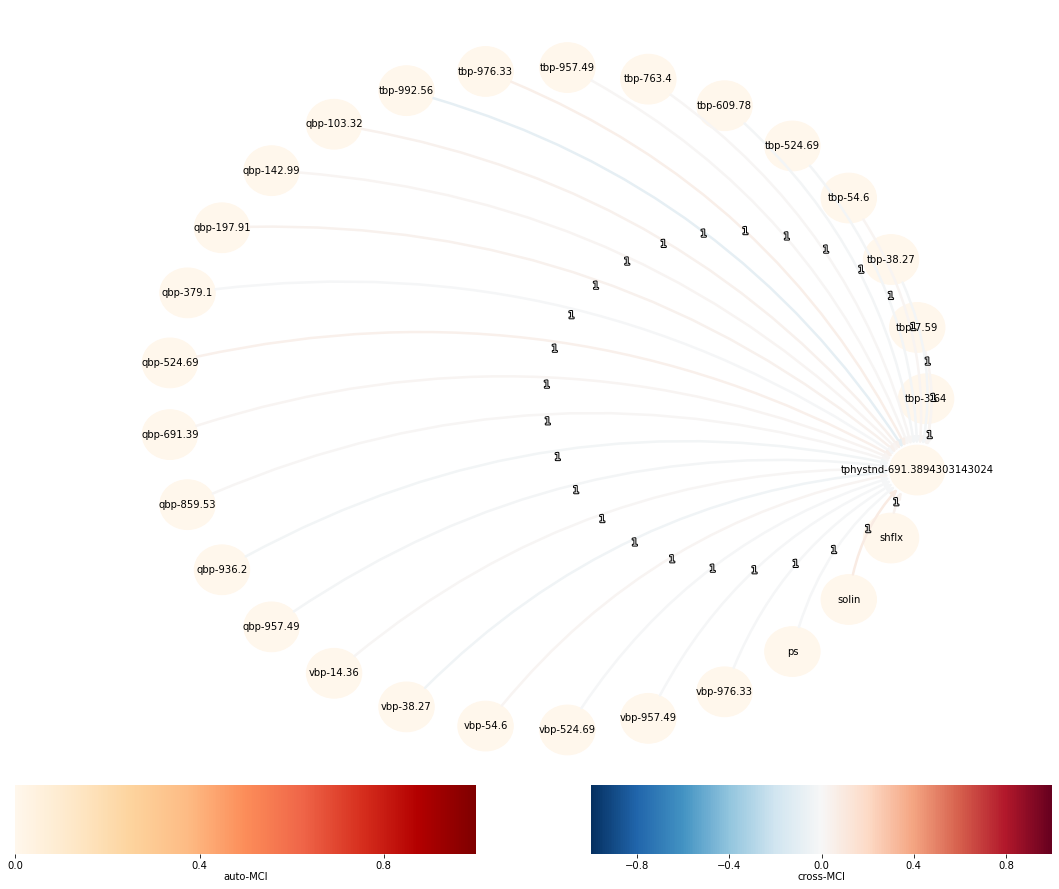

Plotted. Time: 0:00:45.119105
Loading results from "causal_links/tphystnd_22_lat-4_lon-120_002_train_1_year.obj"
Plotting links for tphystnd at level 22
pc_alpha = 0.001


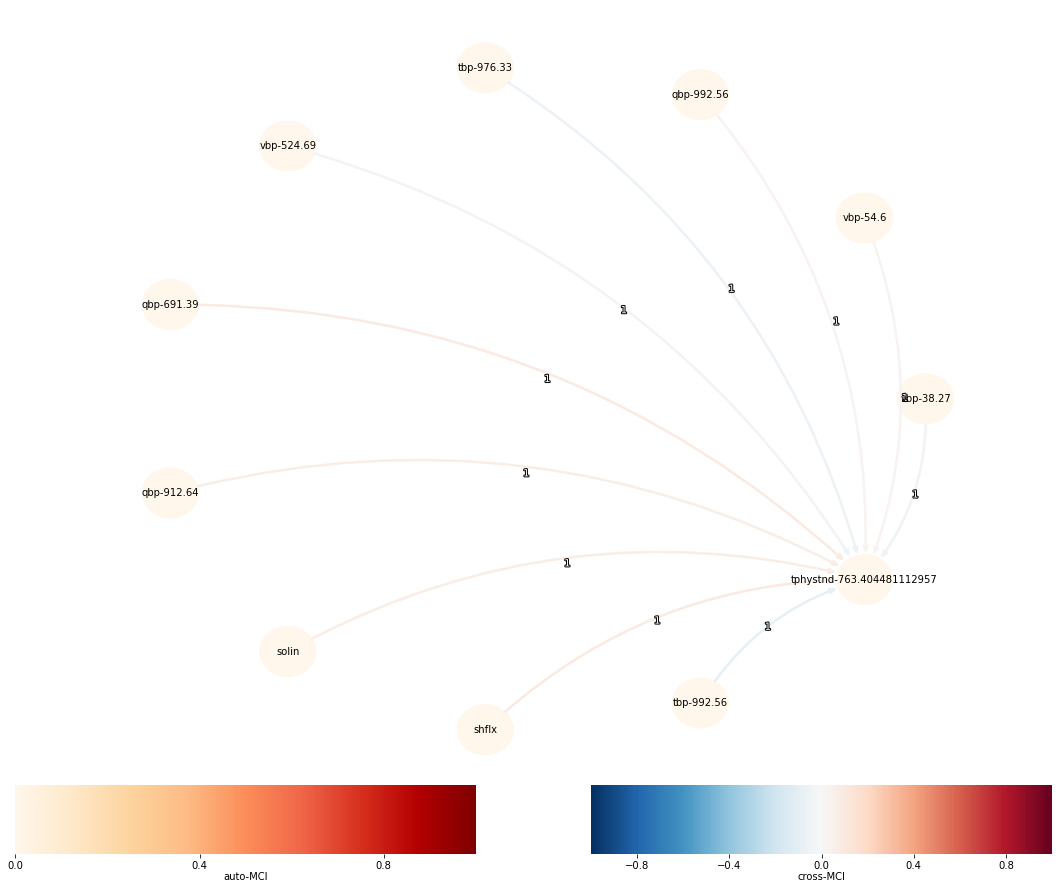

pc_alpha = 0.002


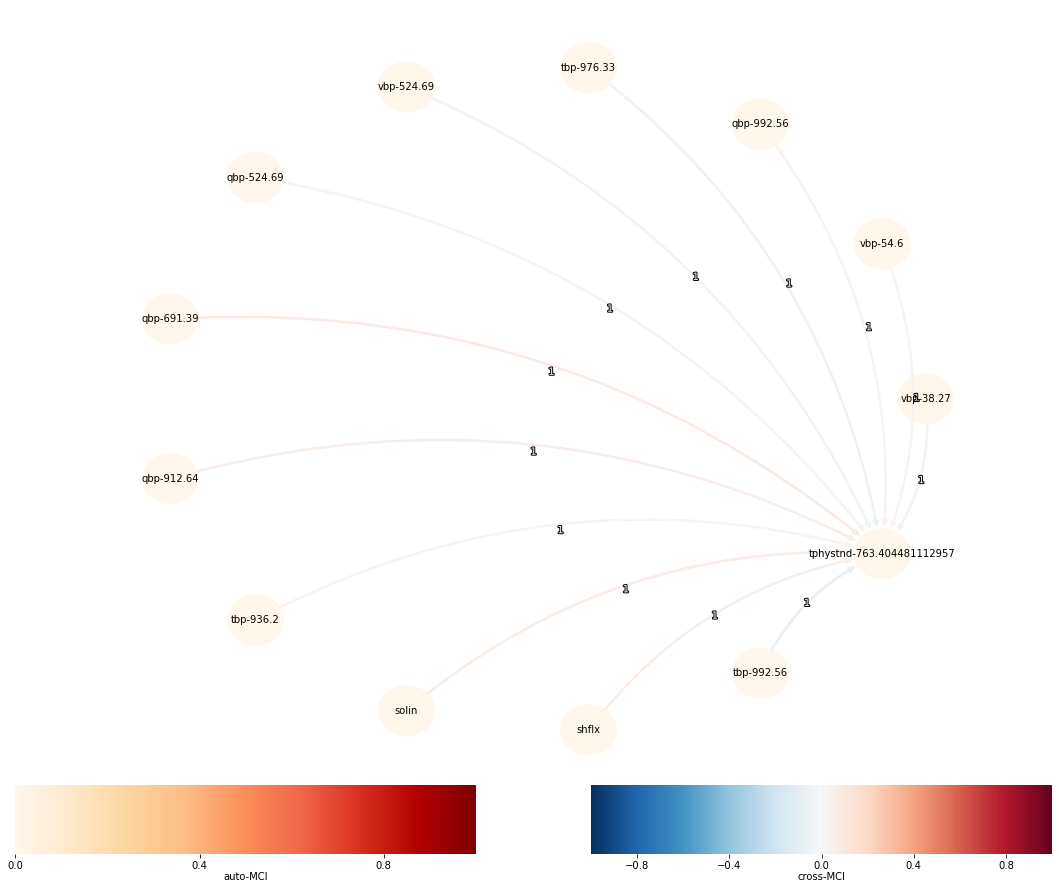

pc_alpha = 0.005


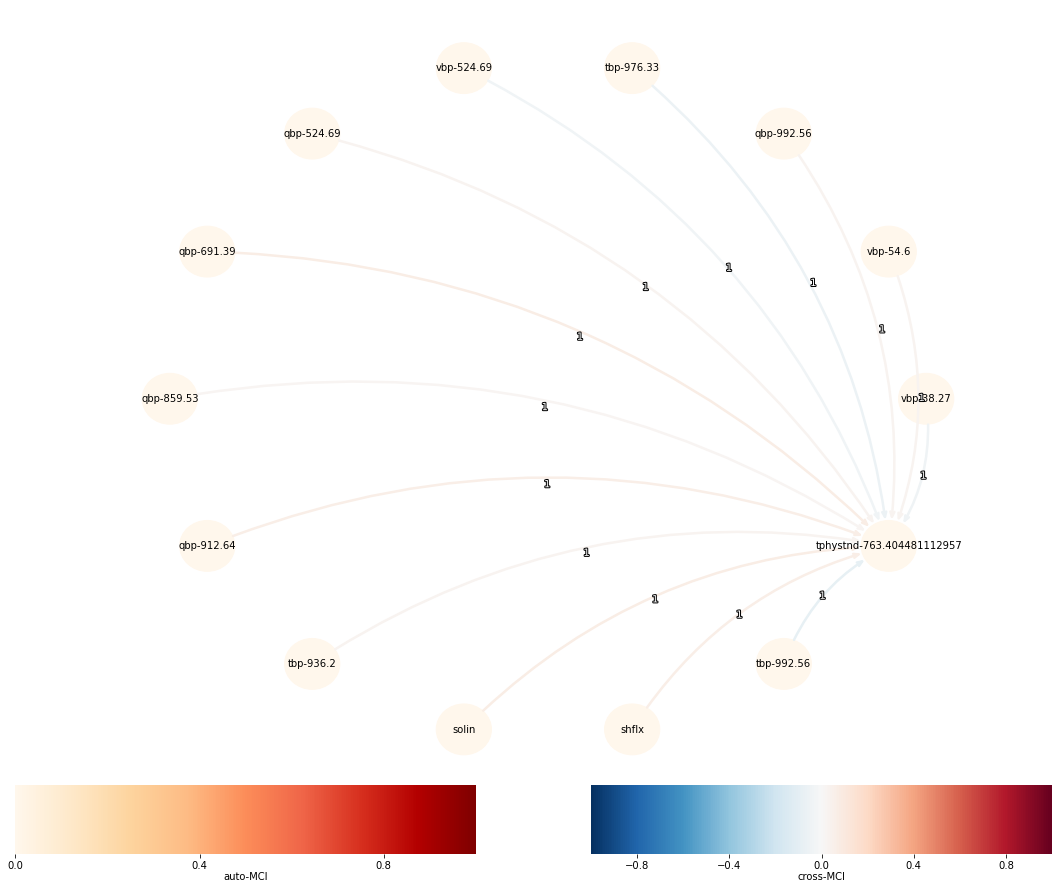

pc_alpha = 0.01


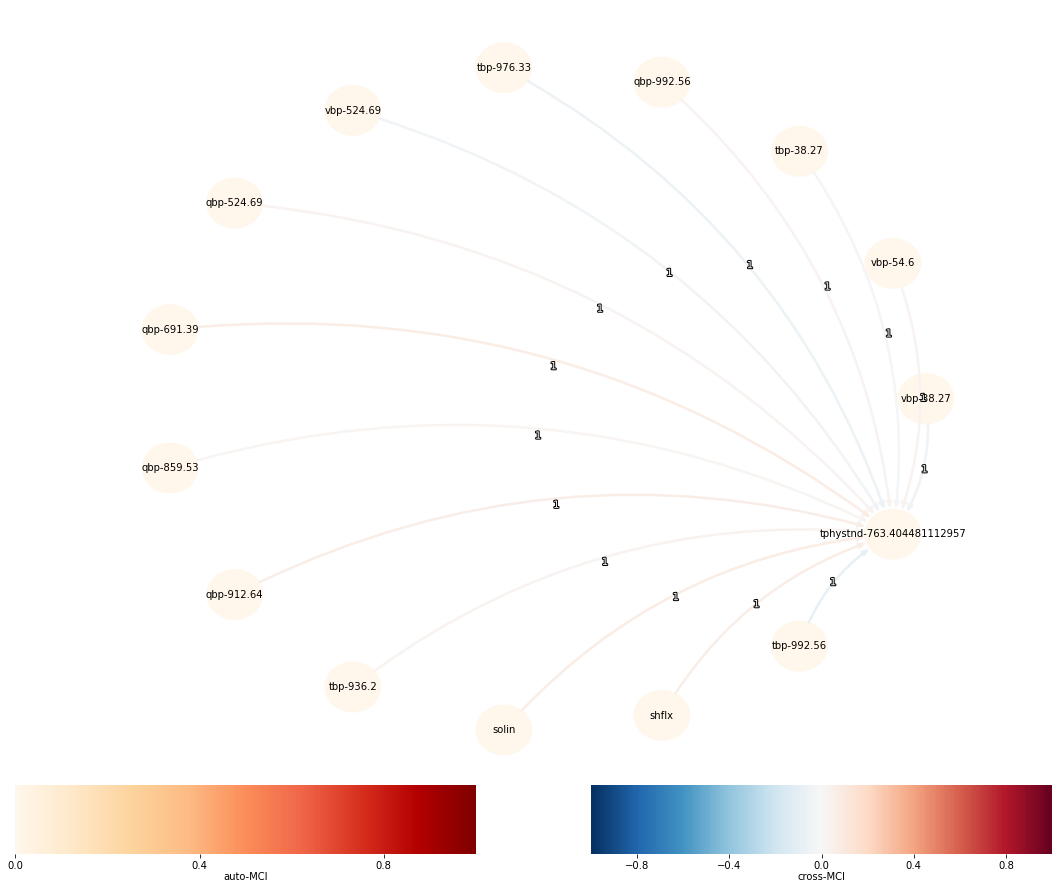

pc_alpha = 0.02


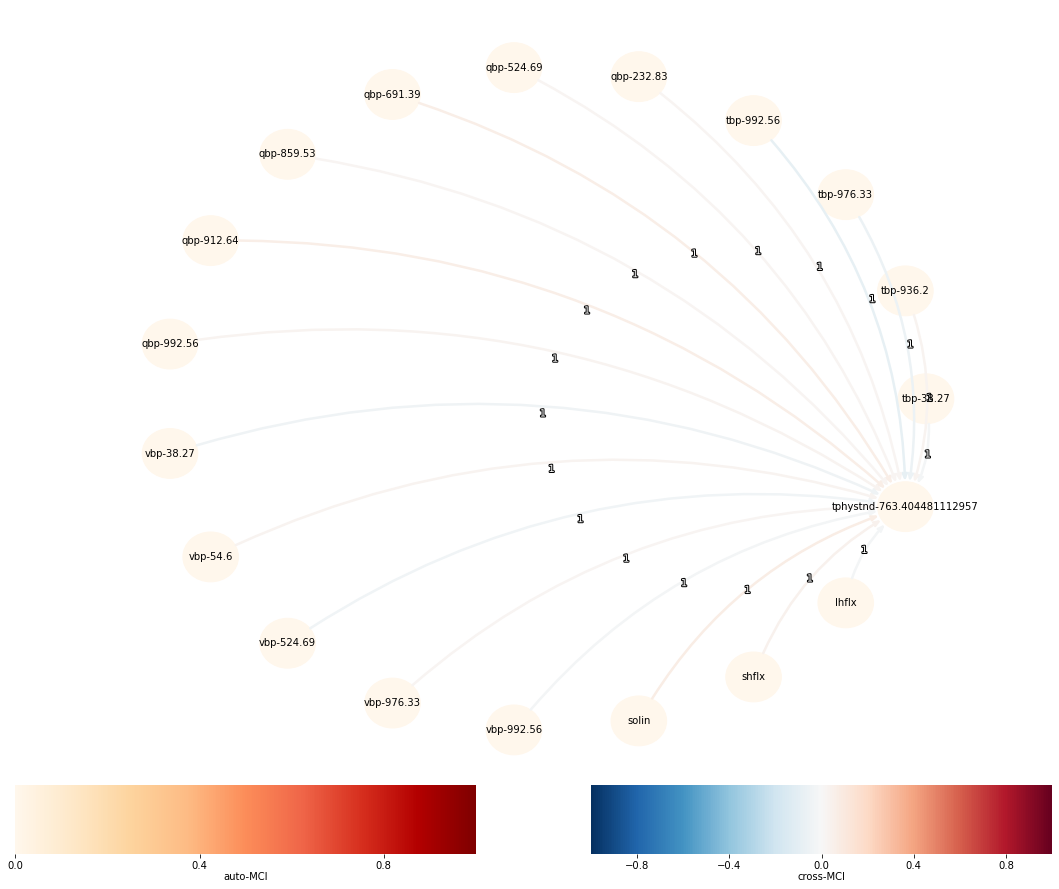

pc_alpha = 0.05


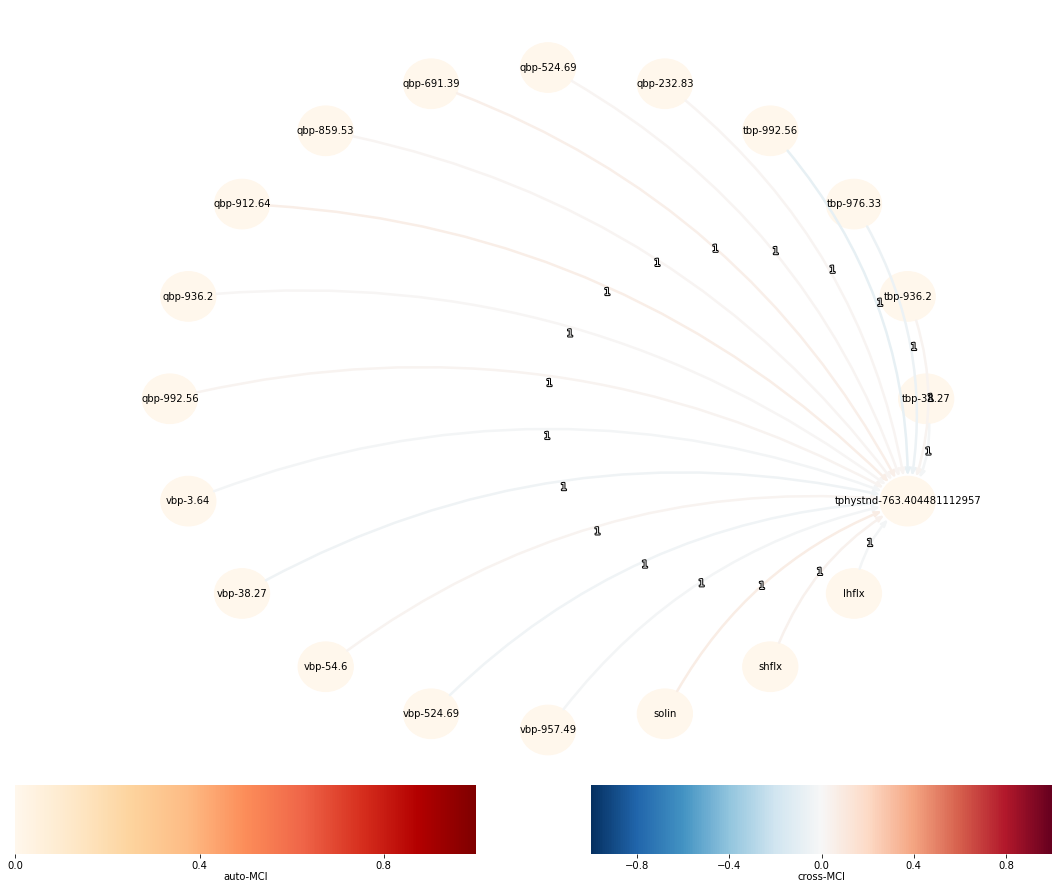

pc_alpha = 0.1


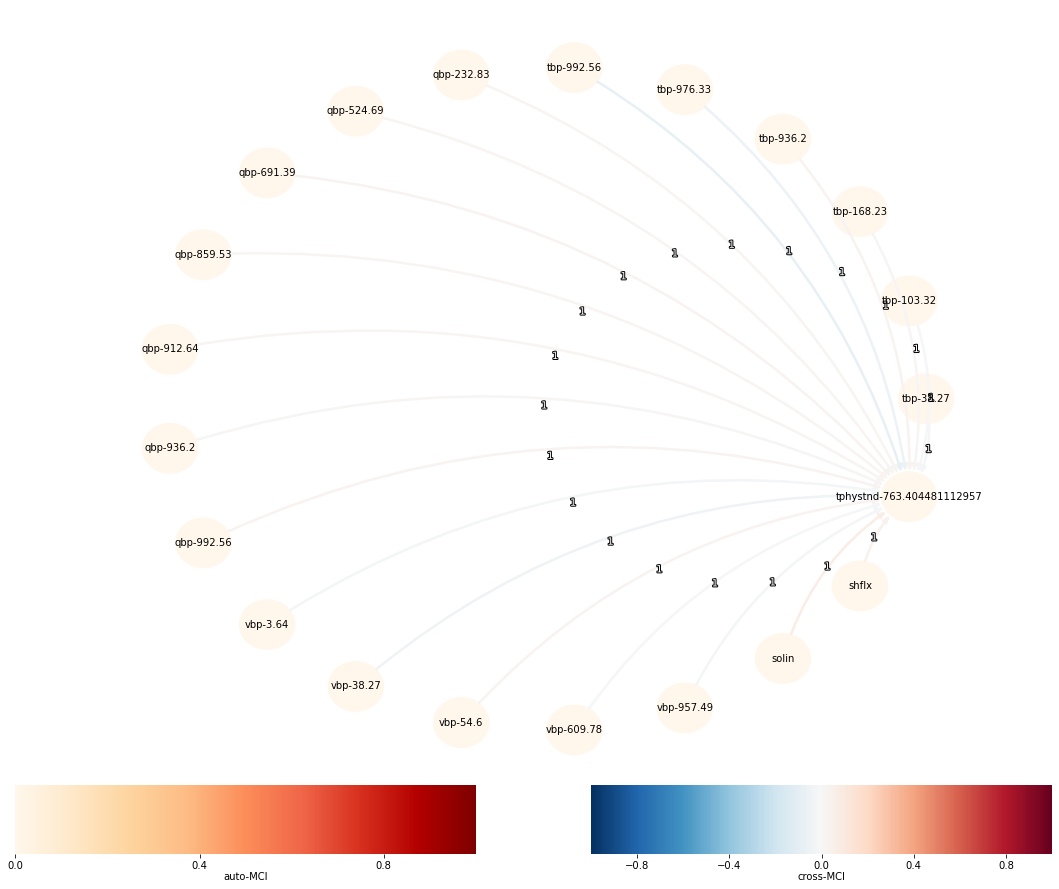

pc_alpha = 0.2


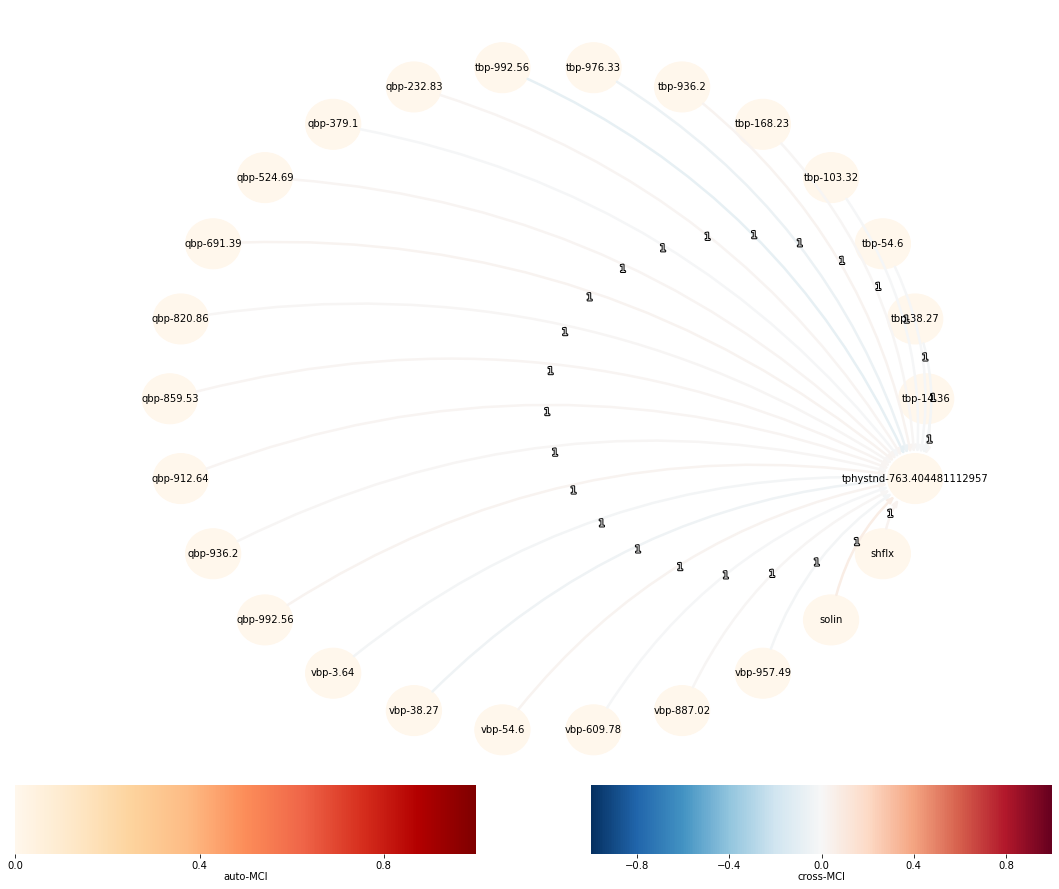

Plotted. Time: 0:00:32.754527
Loading results from "causal_links/tphystnd_23_lat-4_lon-120_002_train_1_year.obj"
Plotting links for tphystnd at level 23
pc_alpha = 0.001


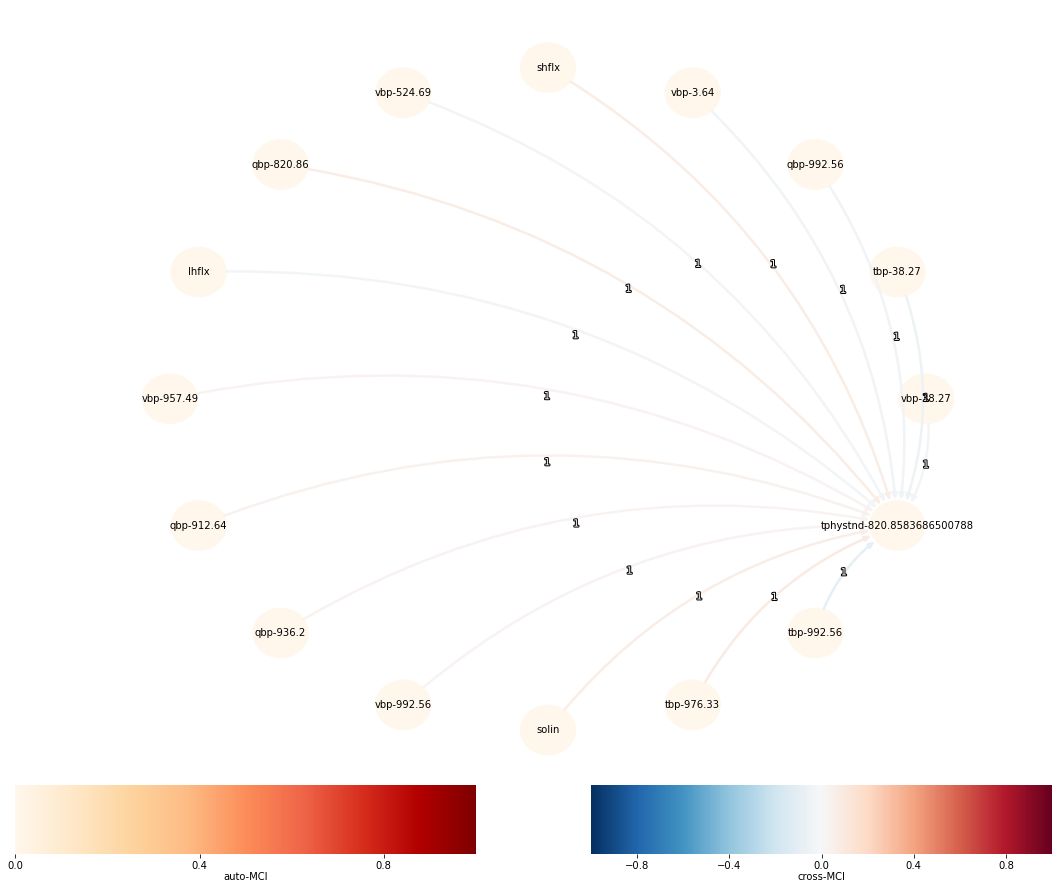

pc_alpha = 0.002


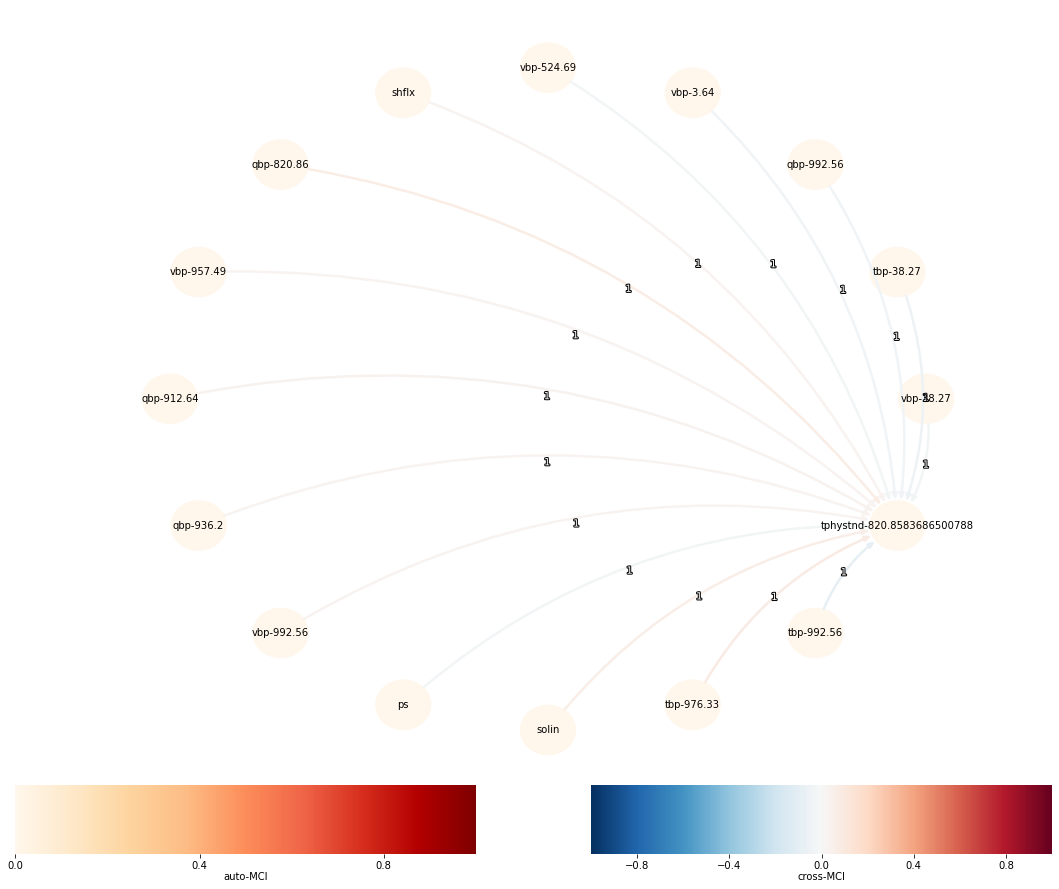

pc_alpha = 0.005


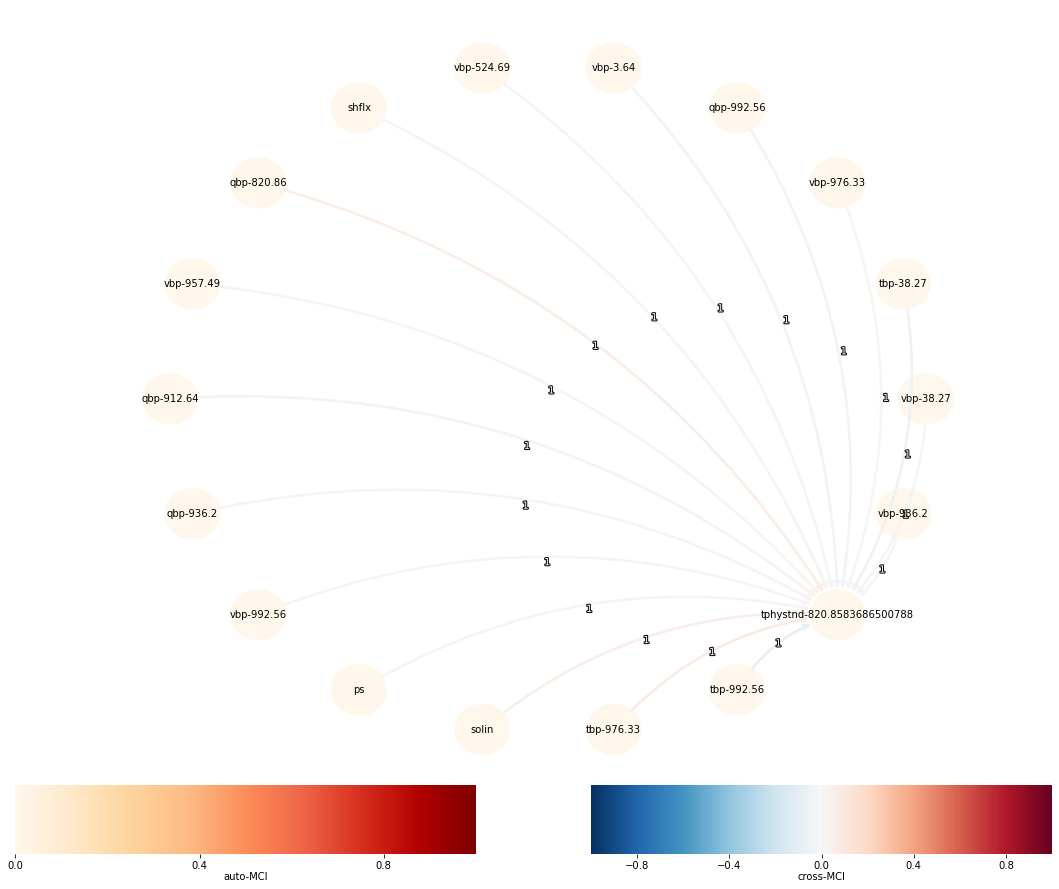

pc_alpha = 0.01


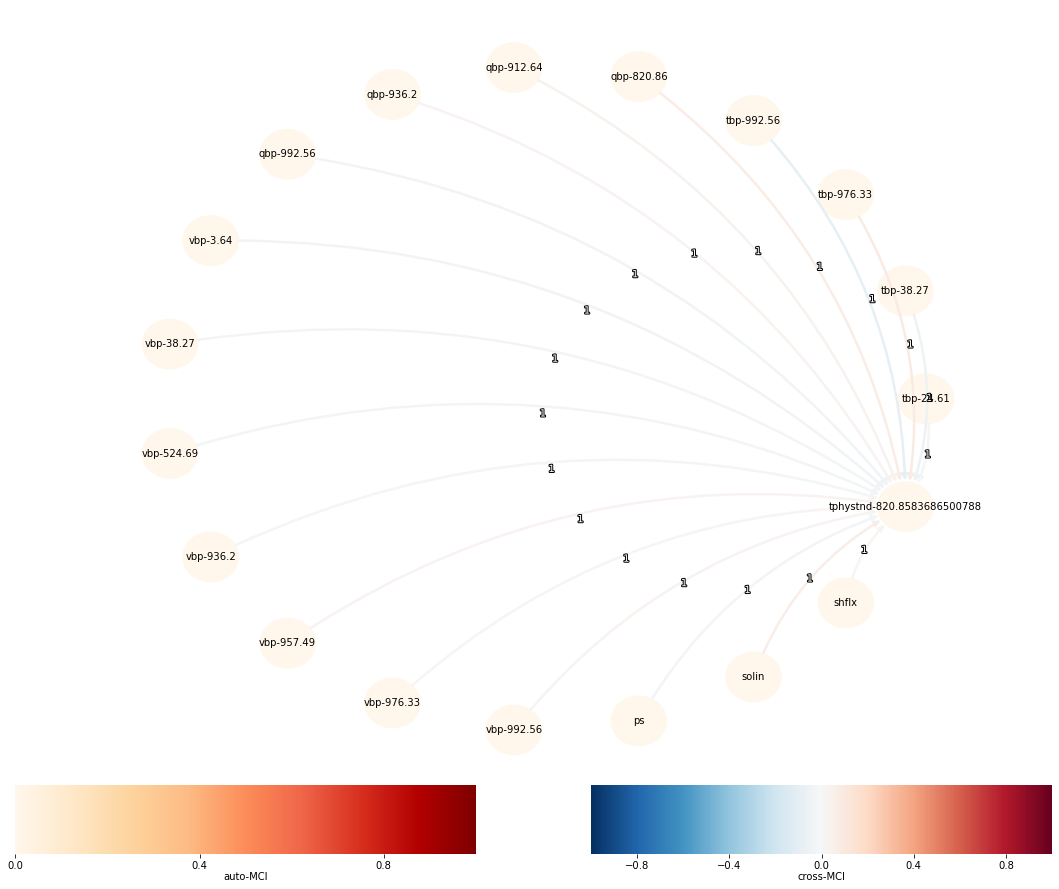

pc_alpha = 0.02


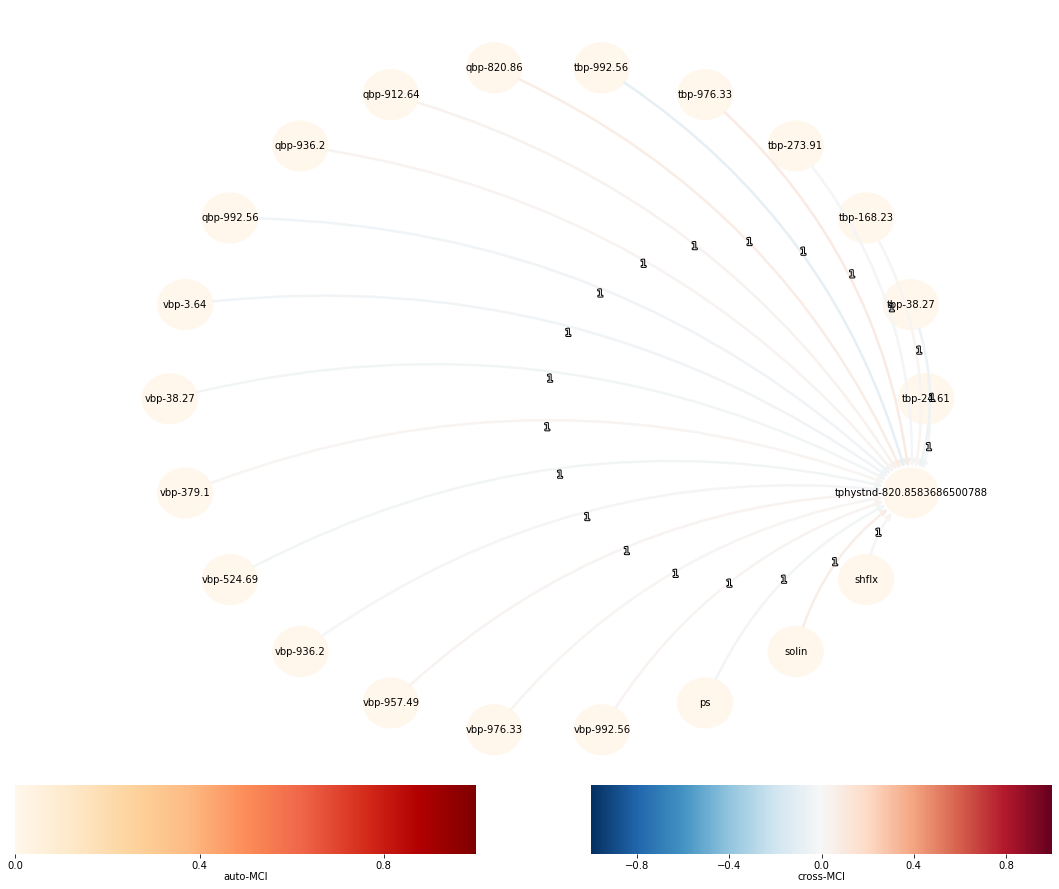

pc_alpha = 0.05


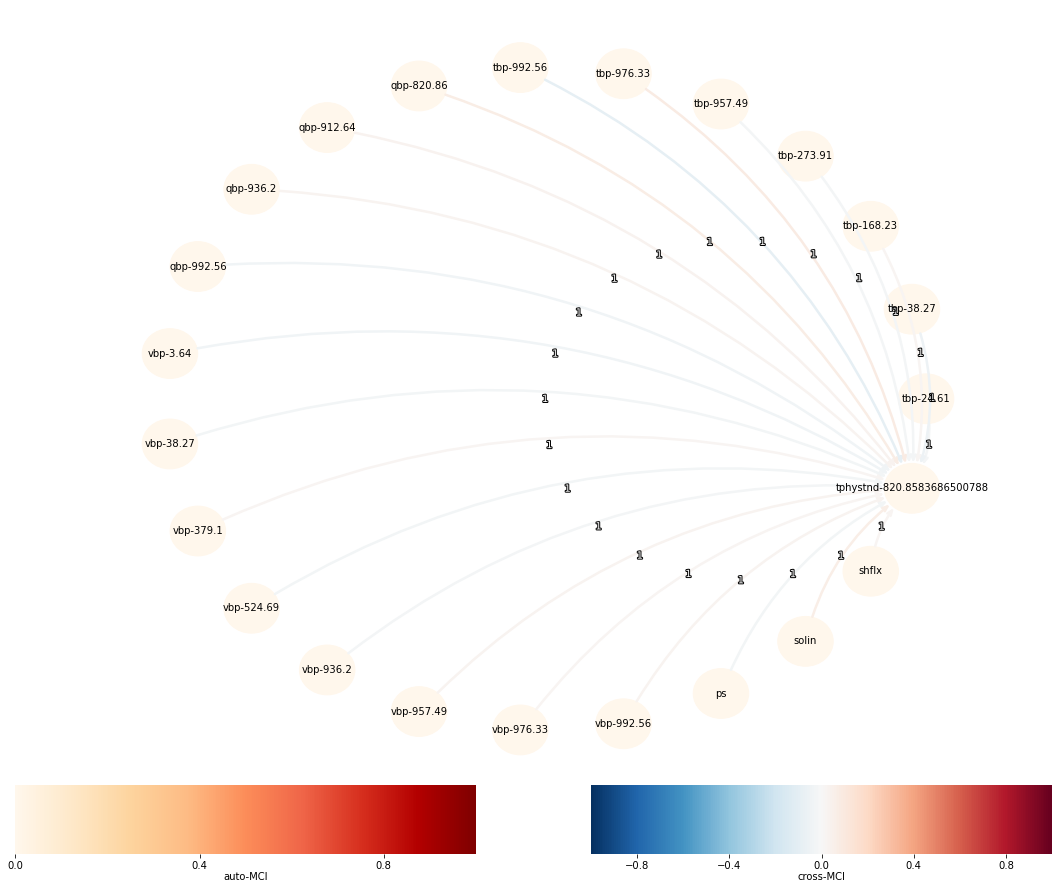

pc_alpha = 0.1


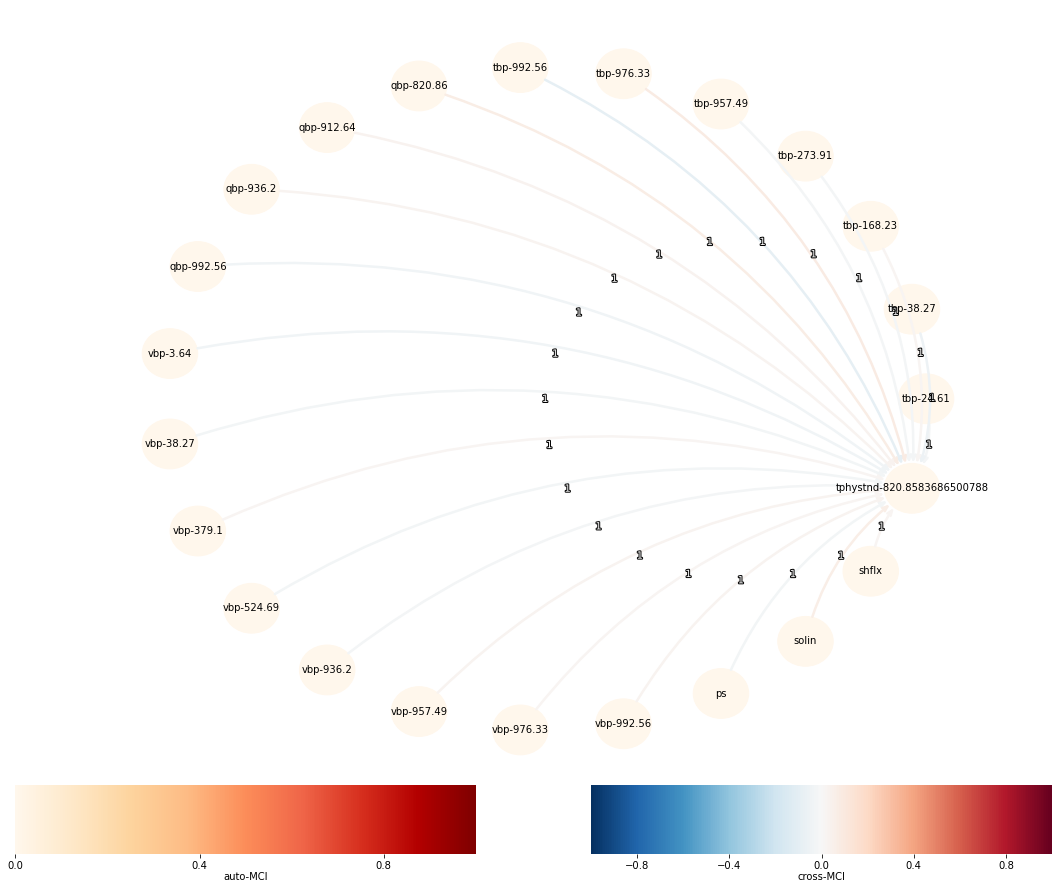

pc_alpha = 0.2


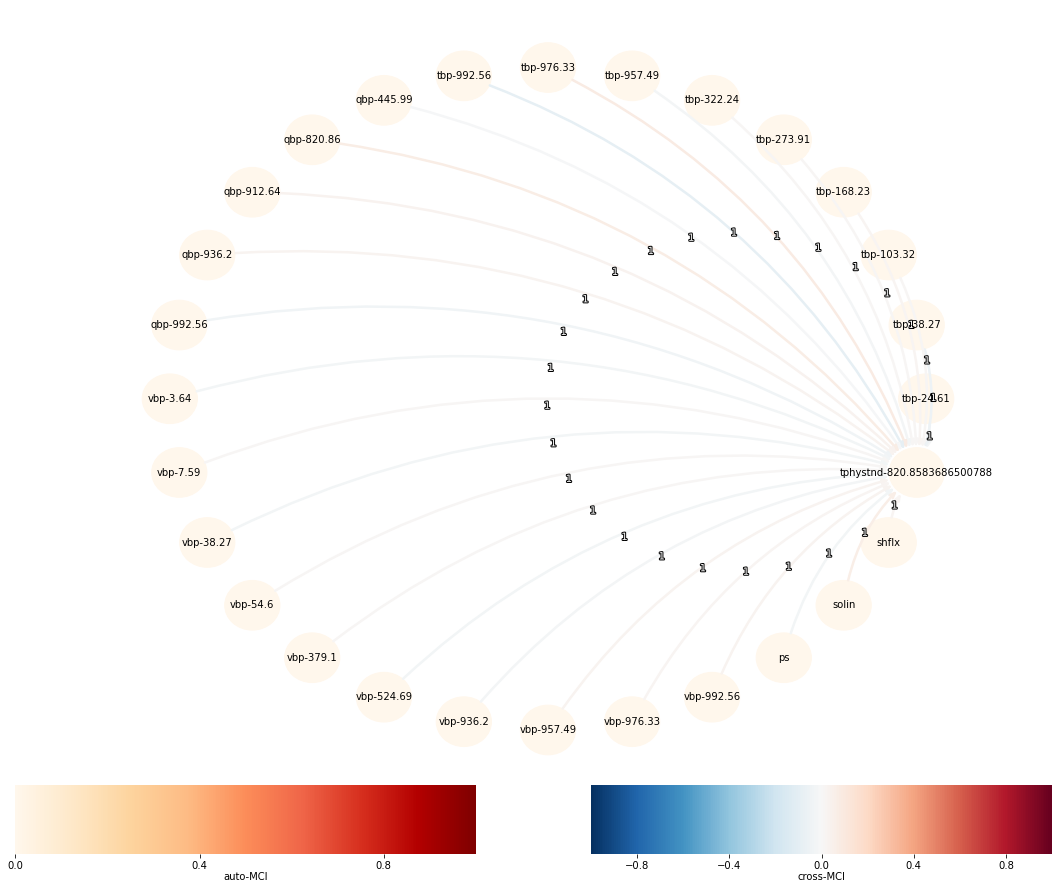

Plotted. Time: 0:00:37.265946
Loading results from "causal_links/tphystnd_24_lat-4_lon-120_002_train_1_year.obj"
Plotting links for tphystnd at level 24
pc_alpha = 0.001


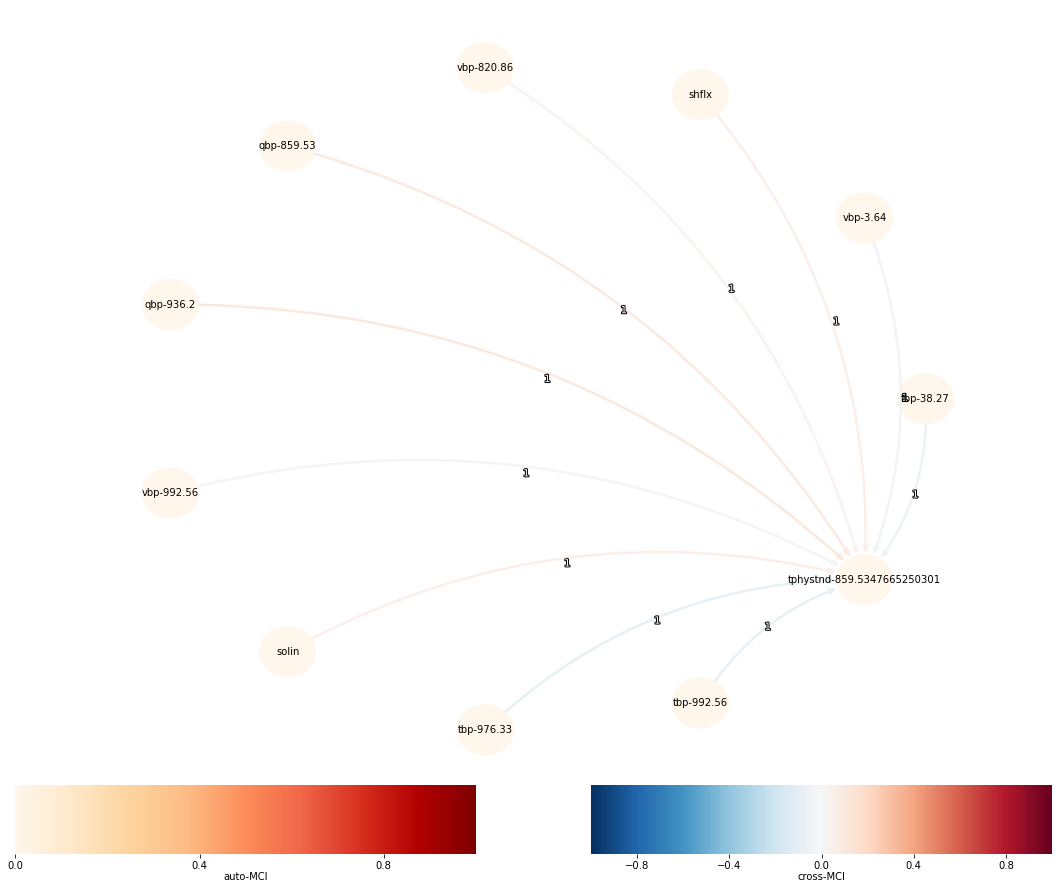

pc_alpha = 0.002


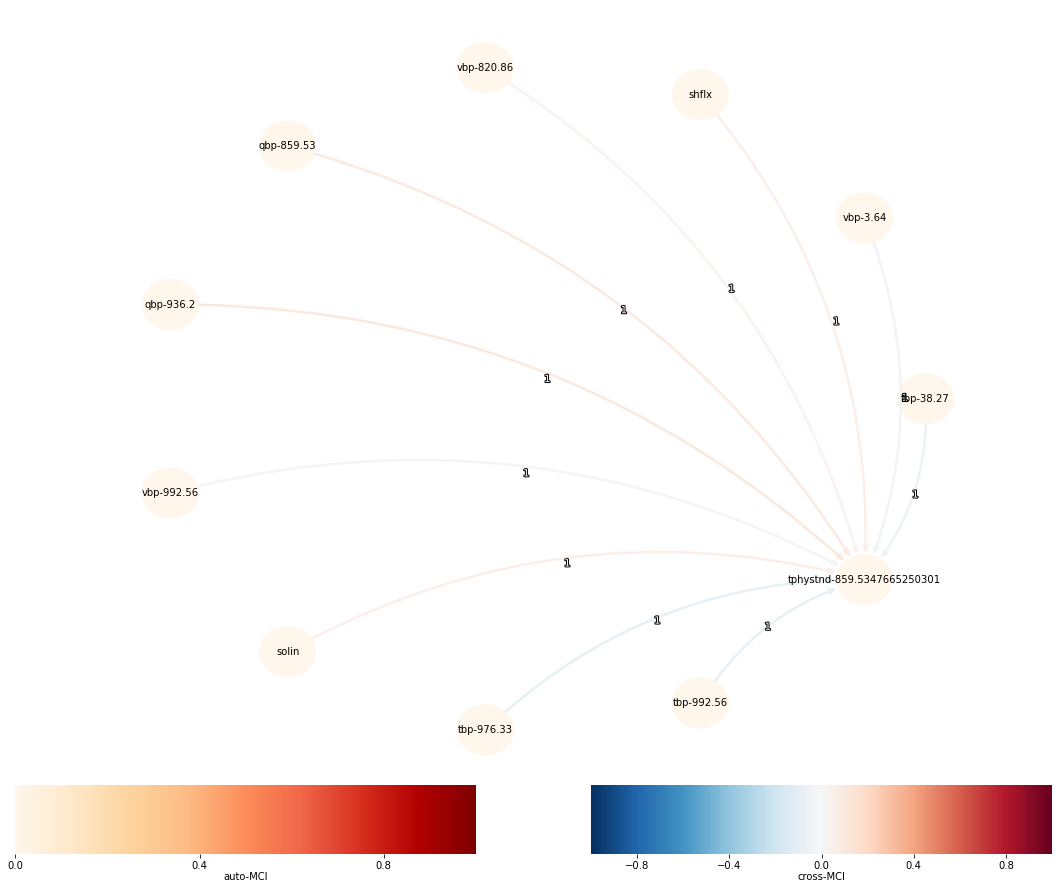

pc_alpha = 0.005


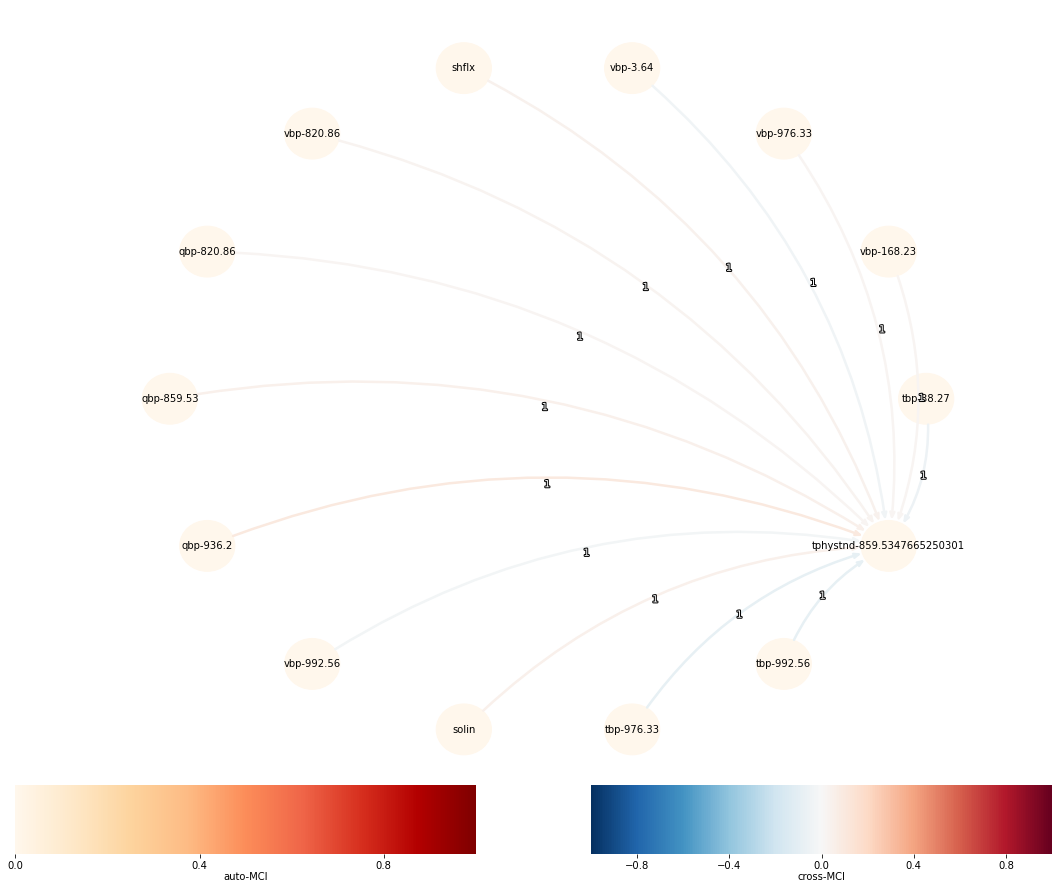

pc_alpha = 0.01


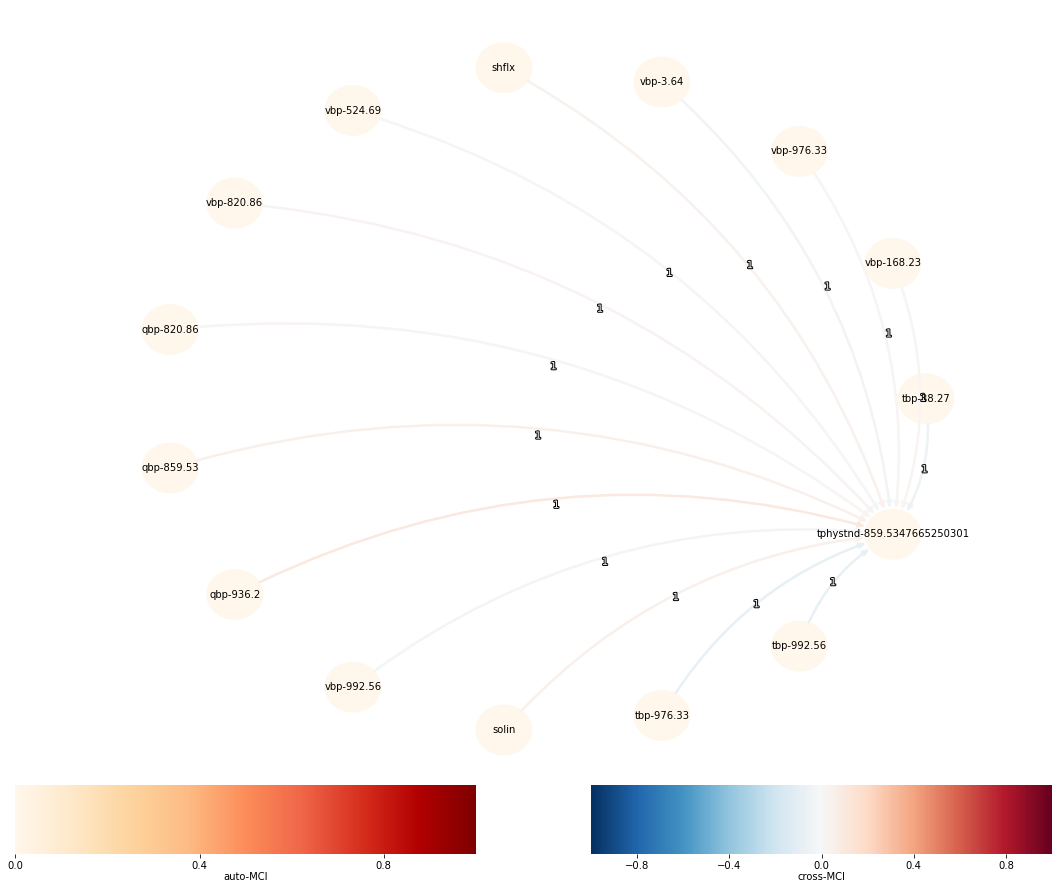

pc_alpha = 0.02


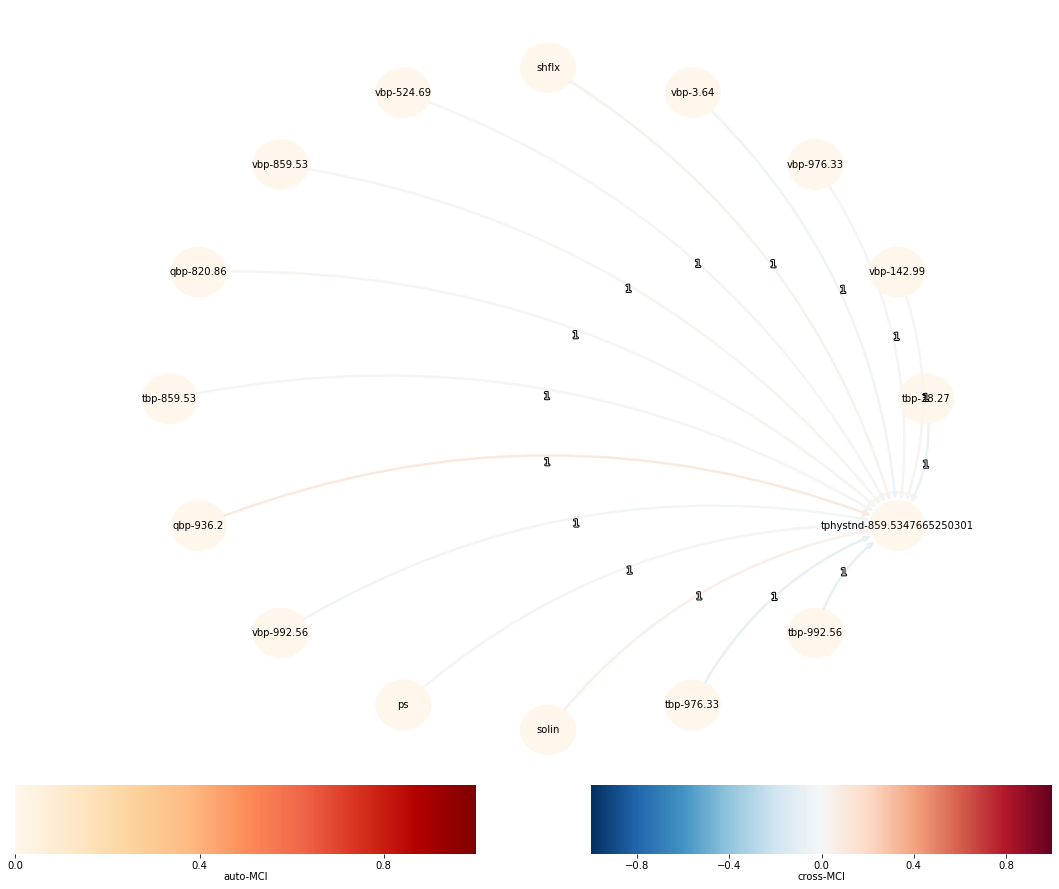

pc_alpha = 0.05


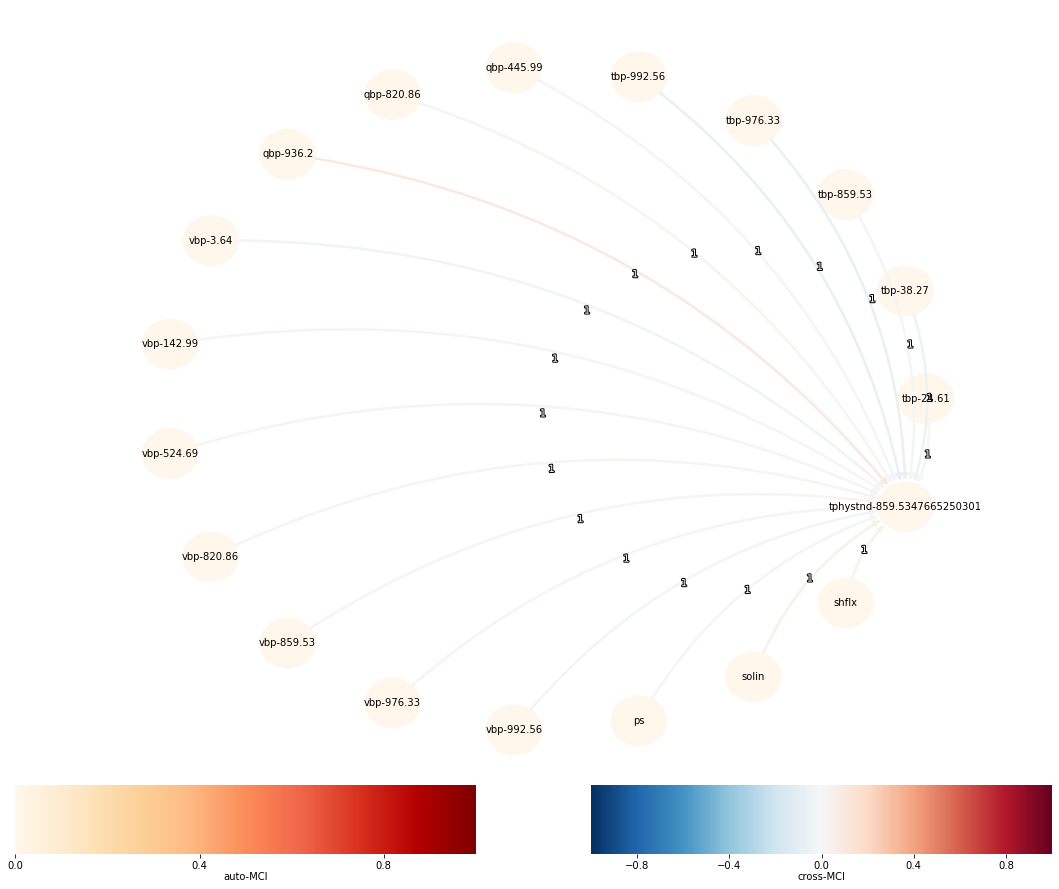

pc_alpha = 0.1


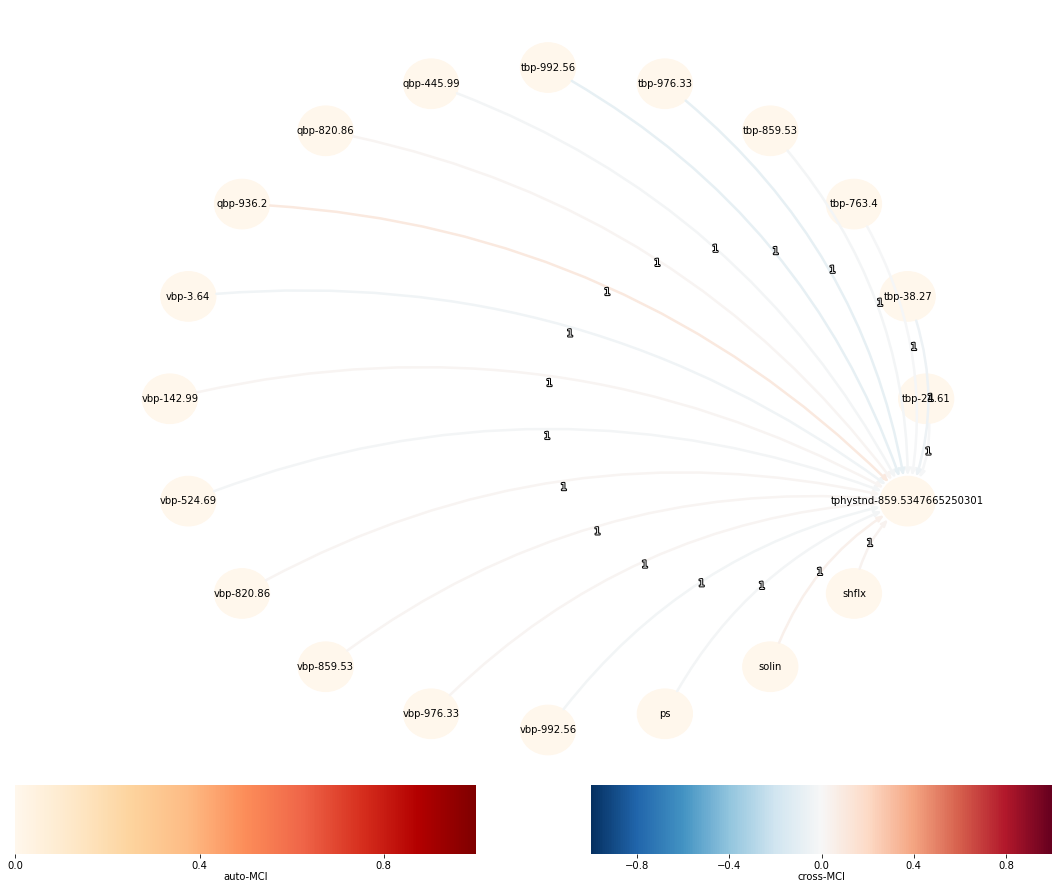

pc_alpha = 0.2


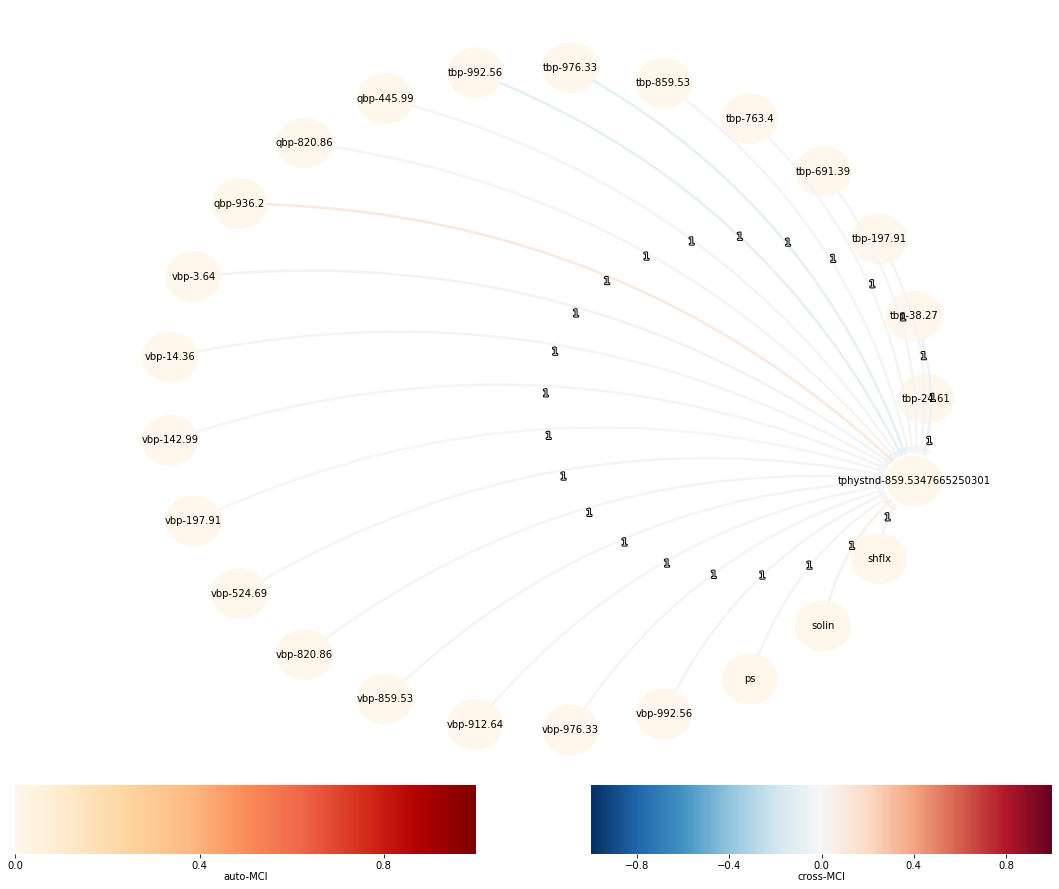

Plotted. Time: 0:00:31.378479
Variable: flns
Loading results from "causal_links/flns_1_lat-4_lon-120_002_train_1_year.obj"
Plotting links for flns at level 1
pc_alpha = 0.001


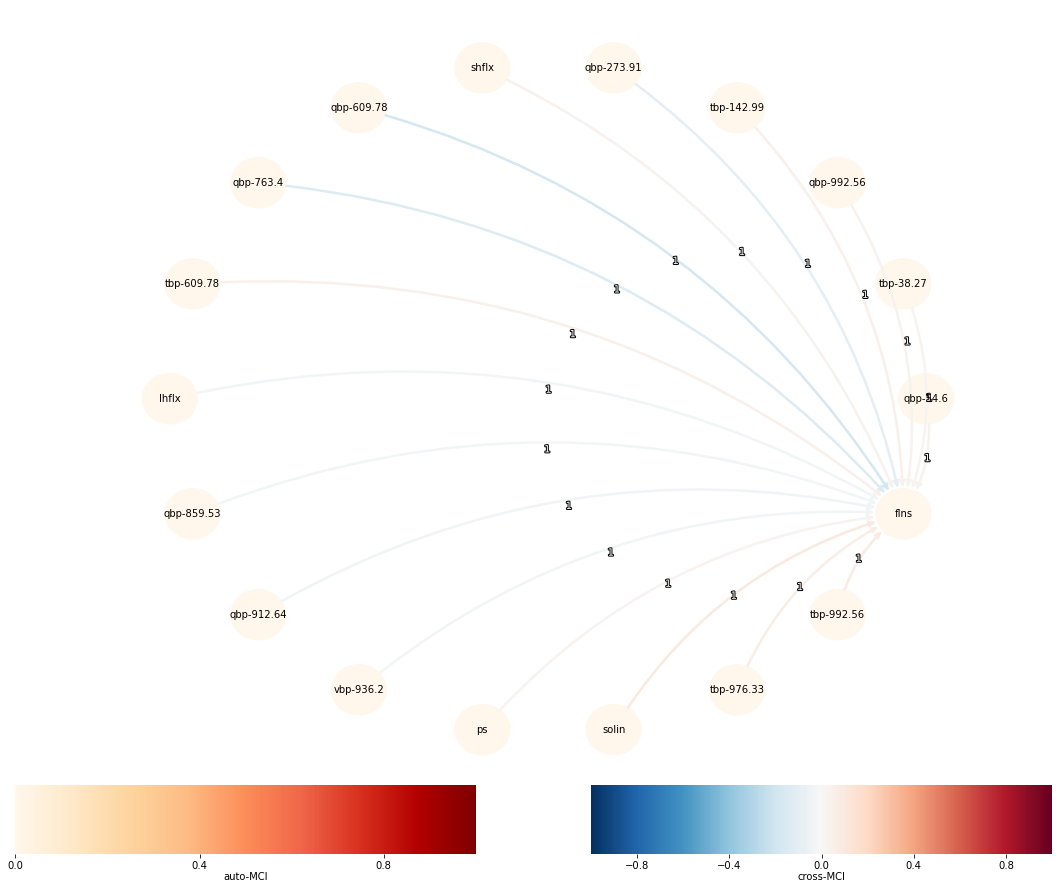

pc_alpha = 0.002


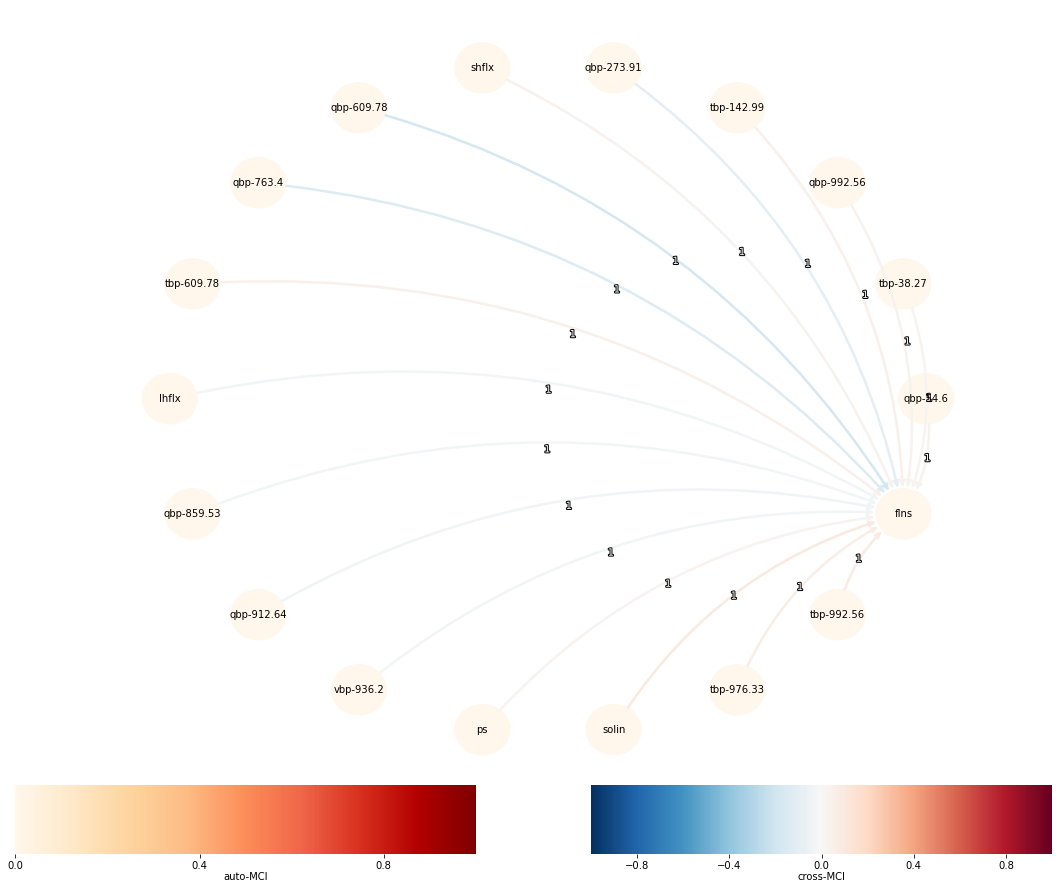

pc_alpha = 0.005


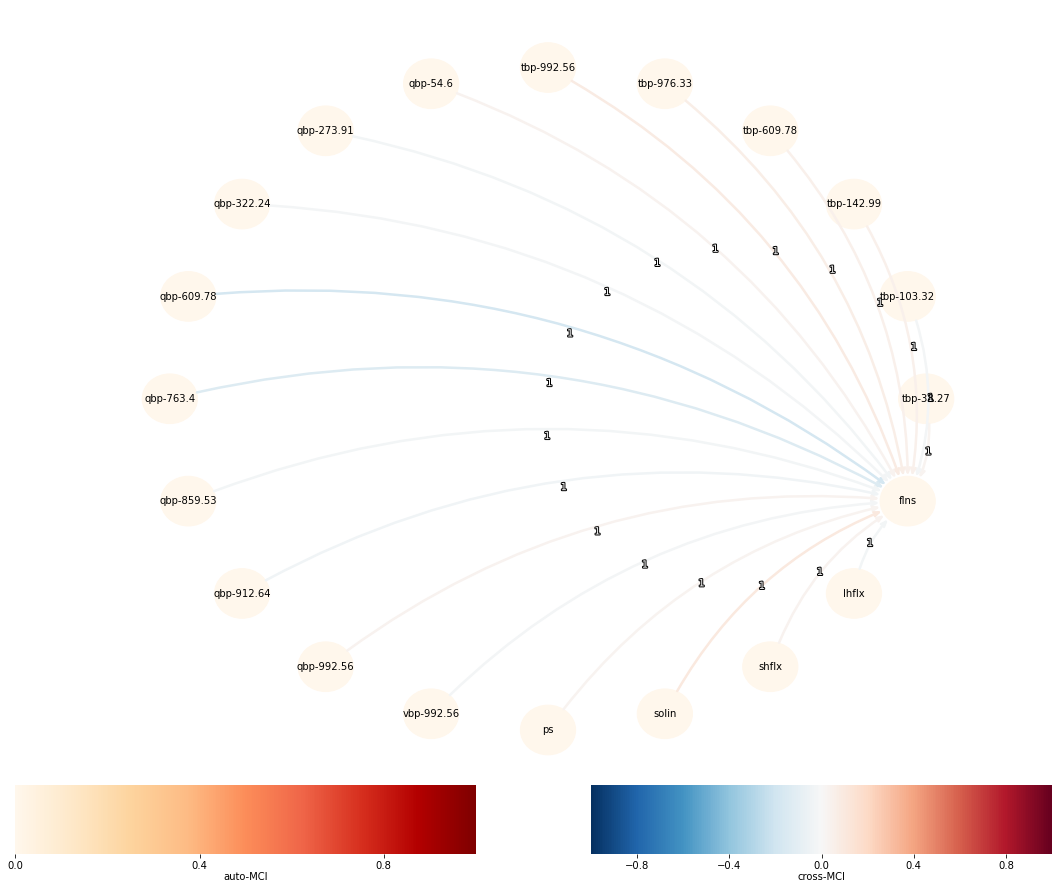

pc_alpha = 0.01


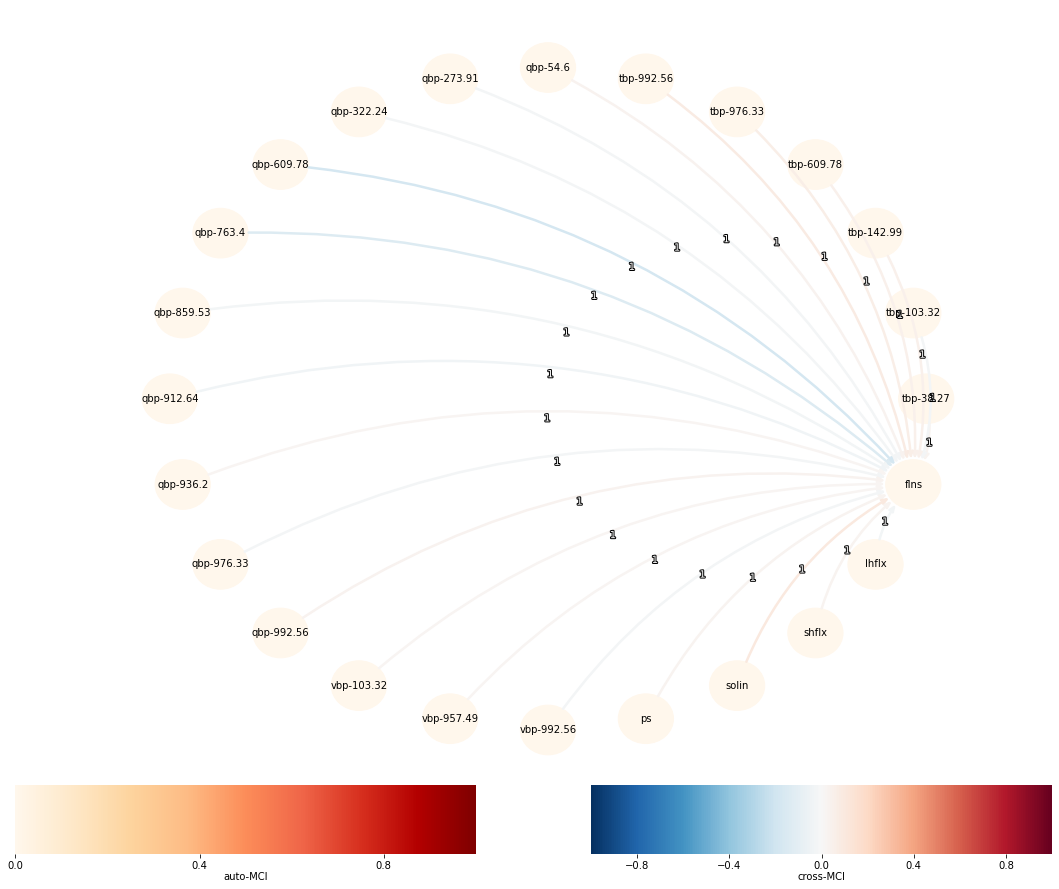

pc_alpha = 0.02


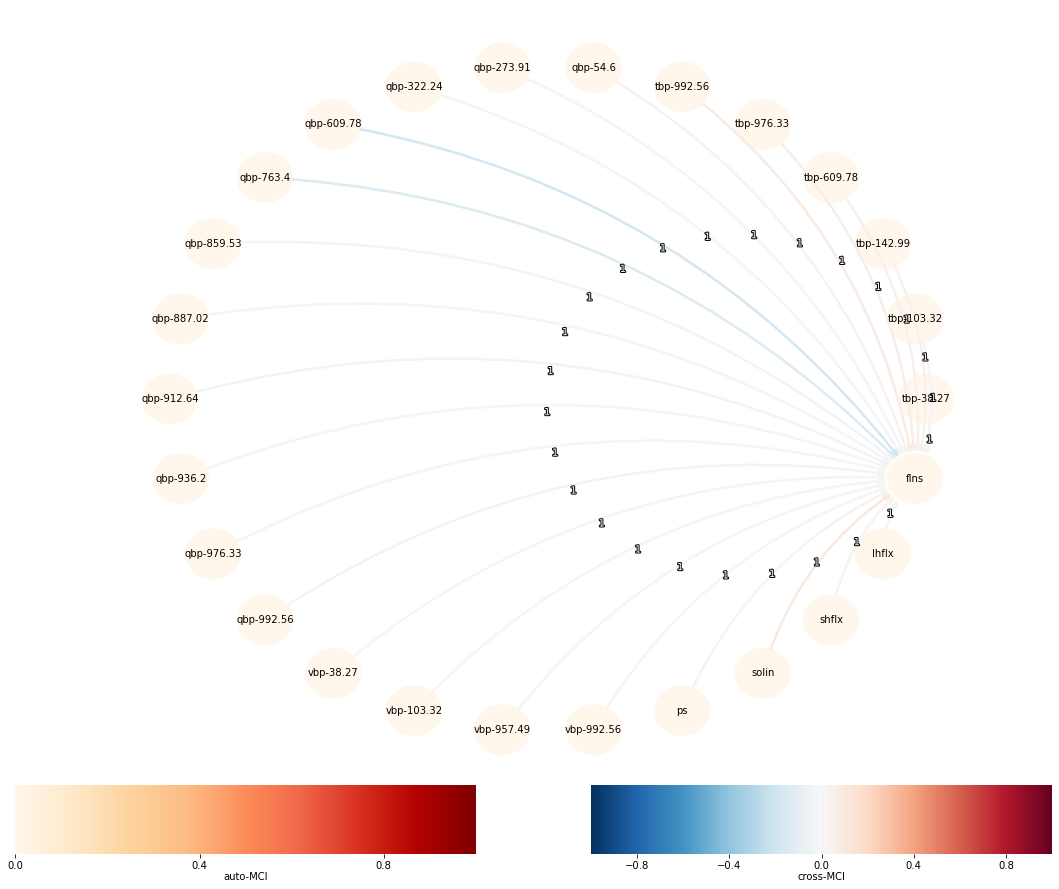

pc_alpha = 0.05


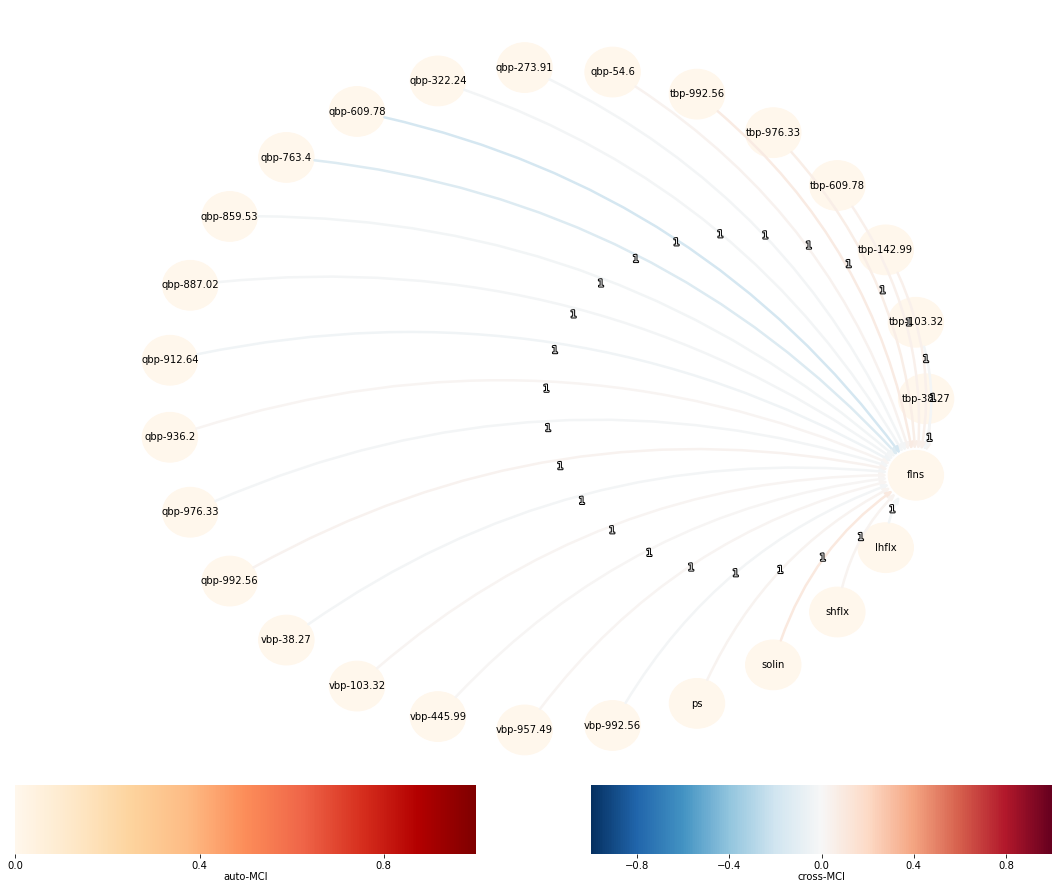

pc_alpha = 0.1


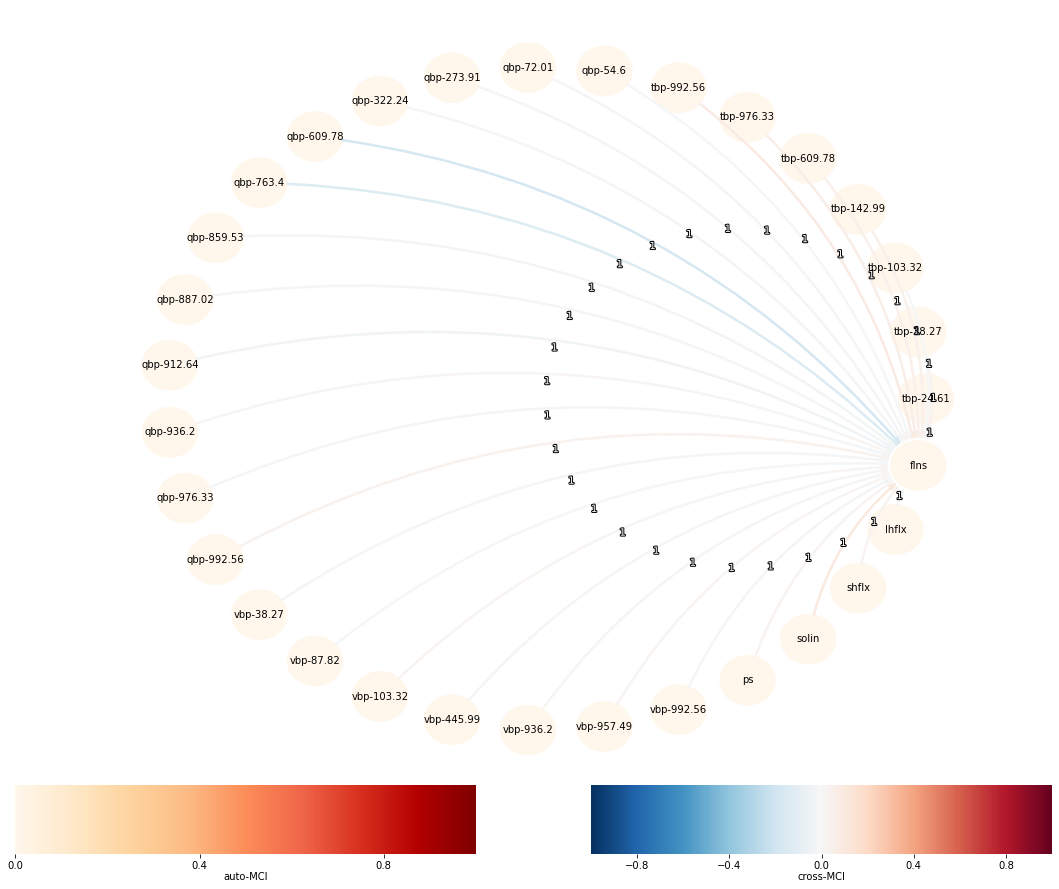

pc_alpha = 0.2


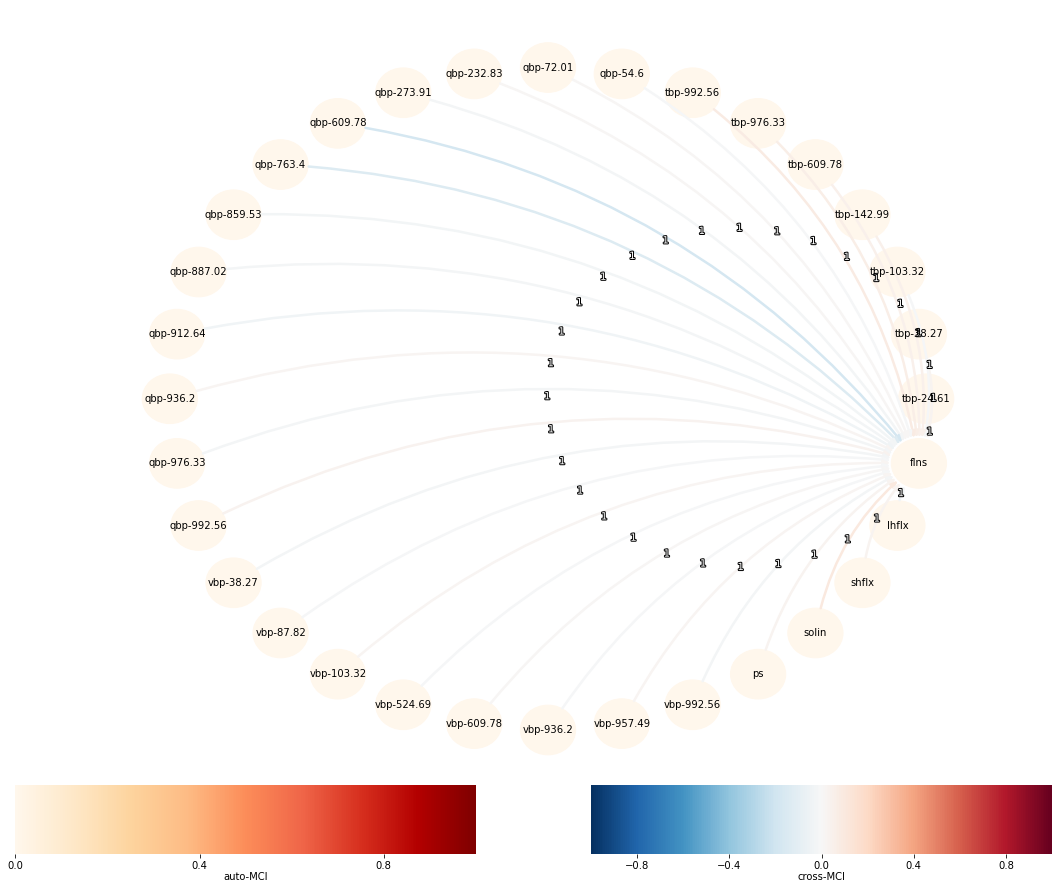

Plotted. Time: 0:00:53.333080
All links in gridpoint plotted. Time: 0:03:20.220216
Execution complete. Total time: 0:03:20.251554


In [9]:

# Load data
len_grid = len(gridpoints)
t_start = time.time()
for i_grid, (lat, lon) in enumerate(gridpoints):
    idx_lat = idx_lats[i_grid]
    idx_lon = idx_lons[i_grid]
    
    t_start_gridpoint = time.time()
    print(f"Gridpoint {i_grid+1}/{len_grid}:"
          + f"lat={lat} ({idx_lat}), lon={lon} ({idx_lon})")
    for child in var_children:
        print(f"Variable: {child.name}")
        if child.dimensions == 2:
            child_levels = [[levels[-1],0]]
        elif child.dimensions == 3:
            child_levels = children_idx_levs
        for level in child_levels:
            results = utils.load_results(child, level[1], lat, lon,
                                         experiment, output_folder)

            print(f"Plotting links for {child.name} at level {level[1]+1}")
            t_before_plot_linkgs = time.time()
            # Plotting
            for pc_alpha, alpha_result in results.items():
                print(f"pc_alpha = {pc_alpha}")
                plot_file = Path(plots_folder, PLOT_FILE_PATTERN.format(
                        var_name = child.name,
                        level = level[1]+1,
                        lat = int(lat),
                        lon = int(lon),
                        pc_alpha = pc_alpha,
                        experiment = experiment
                ))
                if not overwrite and plot_file.is_file():
                    print(f"Found file {plot_file}, skipping.")
                    continue # Ignore this result
                plot_links(alpha_result, save_name = plot_file)
            time_plot_links = datetime.timedelta(
                    seconds = time.time() - t_before_plot_linkgs
            )
            print(f"Plotted. Time: {time_plot_links}")

    time_point = datetime.timedelta(
            seconds = time.time() - t_start_gridpoint)
    print(f"All links in gridpoint plotted. Time: {time_point}")
total_time = datetime.timedelta(seconds = time.time() - t_start)
print(f"Execution complete. Total time: {total_time}")
    

## Aggregate results

In [10]:
def get_parents_from_links(links):
    linked_variables = set() # Avoids duplicates and sorts when list
    for parents_list in links.values():
        if len(parents_list) > 0:
            linked_variables.add(child)
            for parent in parents_list:
                linked_variables.add(parent[0])
    return [(i in linked_variables)  for i in range(len(links))]

In [11]:
import numpy as np

KEY_PATTERN = "{var_name}-{level}"

aggregated_results = dict()
for child in var_children:
    print(f"Variable: {child.name}")
    for i_grid, (i_lat, i_lon) in enumerate(gridpoints):

        if child.dimensions == 2:
            child_levels = [idx_levs[0]]
            key = child.name
        elif child.dimensions == 3:
            child_levels = idx_levs
        for level in child_levels:
            if child.dimensions == 3:
                key = KEY_PATTERN.format(
                        var_name = child.name,
                        level = round(level[0], 2)
                )
            aggregated_pc_alpha = aggregated_results.get(key, dict())
            results = load_results(child, level[1], i_lat, i_lon,
                                   experiment, output_folder)
            for pc_alpha, alpha_result in results.items():
                links = alpha_result["links"]
                parents = get_parents_from_links(links)
                aggregated = aggregated_pc_alpha.get(pc_alpha, list())
                aggregated.append(parents)
                aggregated_pc_alpha[pc_alpha] = aggregated
            aggregated_results[key] = aggregated_pc_alpha

Variable: tphystnd


NameError: name 'idx_levs' is not defined

In [ ]:
for child, result in aggregated_results.items():
    print(child)
    for pc_alpha, parents_matrix in result.items():
        parents_matrix = np.array(parents_matrix)
        print(pc_alpha)
        print(parents_matrix.sum(axis = 0) / parents_matrix.shape[0] * 100)


In [ ]:
output_folder

In [ ]:
print(f"{latitudes[5]} {longitudes[120]}")